In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [11]:
from tensorflow import keras
import os
import re


# Load all files from a directory in a DataFrame.

def load_directory_data(directory):
    data = {}
    data['sentence'] = []
    data['sentiment'] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), 'r') as f:
            data['sentence'].append(f.read())
            data['sentiment'].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)


# Merge positive and negative examples, add a polarity column and shuffle.

def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, 'pos'))
    neg_df = load_directory_data(os.path.join(directory, 'neg'))
    pos_df['polarity'] = 1
    neg_df['polarity'] = 0
    return pd.concat([pos_df,
                     neg_df]).sample(frac=1).reset_index(drop=True)


# Download and process the dataset files.

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(fname='aclImdb.tar.gz',
            origin='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
            , extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset),
                            'aclImdb', 'train'))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset),
                           'aclImdb', 'test'))

    return (train_df, test_df)

In [12]:
train, test = download_and_load_datasets()

In [13]:
print(len(train), len(test))

25000 25000


train = train.sample(5000)
test = test.sample(5000)

In [14]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [15]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [16]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [17]:
# This is a path to an uncased (all lowercase) version of BERT

BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'


def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""

    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(
            signature='tokenization_info', as_dict=True)
        with tf.Session() as sess:
            (vocab_file, do_lower_case) = sess.run([
                tokenization_info['vocab_file'],
                tokenization_info['do_lower_case']
            ])

    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)


tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [19]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i read that this did not well , that the story is not solid , that vol ##ckman feels he has failed in some way . < br / > < br / > i disagree . first , it is well executed . vol ##ckman is doing well to not only to try a new technique , but to have a focus that is worth thinking about : would immortality reduce the value of life ? big question . . . < br / > < br / > i can see he trying hard to build a feeling , and he is not com ##promising . this is to be app ##lau ##ded . i am sure it was an interesting exercise to build [SEP]


INFO:tensorflow:tokens: [CLS] i read that this did not well , that the story is not solid , that vol ##ckman feels he has failed in some way . < br / > < br / > i disagree . first , it is well executed . vol ##ckman is doing well to not only to try a new technique , but to have a focus that is worth thinking about : would immortality reduce the value of life ? big question . . . < br / > < br / > i can see he trying hard to build a feeling , and he is not com ##promising . this is to be app ##lau ##ded . i am sure it was an interesting exercise to build [SEP]


INFO:tensorflow:input_ids: 101 1045 3191 2008 2023 2106 2025 2092 1010 2008 1996 2466 2003 2025 5024 1010 2008 5285 24080 5683 2002 2038 3478 1999 2070 2126 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 21090 1012 2034 1010 2009 2003 2092 6472 1012 5285 24080 2003 2725 2092 2000 2025 2069 2000 3046 1037 2047 6028 1010 2021 2000 2031 1037 3579 2008 2003 4276 3241 2055 1024 2052 20107 5547 1996 3643 1997 2166 1029 2502 3160 1012 1012 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2064 2156 2002 2667 2524 2000 3857 1037 3110 1010 1998 2002 2003 2025 4012 25013 1012 2023 2003 2000 2022 10439 17298 5732 1012 1045 2572 2469 2009 2001 2019 5875 6912 2000 3857 102


INFO:tensorflow:input_ids: 101 1045 3191 2008 2023 2106 2025 2092 1010 2008 1996 2466 2003 2025 5024 1010 2008 5285 24080 5683 2002 2038 3478 1999 2070 2126 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 21090 1012 2034 1010 2009 2003 2092 6472 1012 5285 24080 2003 2725 2092 2000 2025 2069 2000 3046 1037 2047 6028 1010 2021 2000 2031 1037 3579 2008 2003 4276 3241 2055 1024 2052 20107 5547 1996 3643 1997 2166 1029 2502 3160 1012 1012 1012 1026 7987 1013 1028 1026 7987 1013 1028 1045 2064 2156 2002 2667 2524 2000 3857 1037 3110 1010 1998 2002 2003 2025 4012 25013 1012 2023 2003 2000 2022 10439 17298 5732 1012 1045 2572 2469 2009 2001 2019 5875 6912 2000 3857 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] well , you might not actually see any women in love in this movie , but you ' ll certainly hear women talking about love , and men talking about love , and women talking about men , and men talking about women , and men talking about men , and everyone talking about death , and talking , and talking , until you yourself will want to scream and do something that requires no talking at all , like paint your bedroom or water your plants . < br / > < br / > welcome to the world of d . h . lawrence , where psycho - ba ##bble reigns supreme , and where no one can get down to living a productive [SEP]


INFO:tensorflow:tokens: [CLS] well , you might not actually see any women in love in this movie , but you ' ll certainly hear women talking about love , and men talking about love , and women talking about men , and men talking about women , and men talking about men , and everyone talking about death , and talking , and talking , until you yourself will want to scream and do something that requires no talking at all , like paint your bedroom or water your plants . < br / > < br / > welcome to the world of d . h . lawrence , where psycho - ba ##bble reigns supreme , and where no one can get down to living a productive [SEP]


INFO:tensorflow:input_ids: 101 2092 1010 2017 2453 2025 2941 2156 2151 2308 1999 2293 1999 2023 3185 1010 2021 2017 1005 2222 5121 2963 2308 3331 2055 2293 1010 1998 2273 3331 2055 2293 1010 1998 2308 3331 2055 2273 1010 1998 2273 3331 2055 2308 1010 1998 2273 3331 2055 2273 1010 1998 3071 3331 2055 2331 1010 1998 3331 1010 1998 3331 1010 2127 2017 4426 2097 2215 2000 6978 1998 2079 2242 2008 5942 2053 3331 2012 2035 1010 2066 6773 2115 5010 2030 2300 2115 4264 1012 1026 7987 1013 1028 1026 7987 1013 1028 6160 2000 1996 2088 1997 1040 1012 1044 1012 5623 1010 2073 18224 1011 8670 11362 23481 4259 1010 1998 2073 2053 2028 2064 2131 2091 2000 2542 1037 13318 102


INFO:tensorflow:input_ids: 101 2092 1010 2017 2453 2025 2941 2156 2151 2308 1999 2293 1999 2023 3185 1010 2021 2017 1005 2222 5121 2963 2308 3331 2055 2293 1010 1998 2273 3331 2055 2293 1010 1998 2308 3331 2055 2273 1010 1998 2273 3331 2055 2308 1010 1998 2273 3331 2055 2273 1010 1998 3071 3331 2055 2331 1010 1998 3331 1010 1998 3331 1010 2127 2017 4426 2097 2215 2000 6978 1998 2079 2242 2008 5942 2053 3331 2012 2035 1010 2066 6773 2115 5010 2030 2300 2115 4264 1012 1026 7987 1013 1028 1026 7987 1013 1028 6160 2000 1996 2088 1997 1040 1012 1044 1012 5623 1010 2073 18224 1011 8670 11362 23481 4259 1010 1998 2073 2053 2028 2064 2131 2091 2000 2542 1037 13318 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i agree totally with another of the reviewers here who was pleased " for the birds " won the oscar in 2002 for " best animated short , " not this sick material , which is pre ##ten ##tious at best and appealing to anyone , of course , who has no belief in heaven or hell . < br / > < br / > the animation was good , but so are a lot of animated shorts . and , by the way , i love dark humor but this just was una ##ppe ##aling from the start . < br / > < br / > as for the story here : a guy walking around and surrounded by nothing but grey ( [SEP]


INFO:tensorflow:tokens: [CLS] i agree totally with another of the reviewers here who was pleased " for the birds " won the oscar in 2002 for " best animated short , " not this sick material , which is pre ##ten ##tious at best and appealing to anyone , of course , who has no belief in heaven or hell . < br / > < br / > the animation was good , but so are a lot of animated shorts . and , by the way , i love dark humor but this just was una ##ppe ##aling from the start . < br / > < br / > as for the story here : a guy walking around and surrounded by nothing but grey ( [SEP]


INFO:tensorflow:input_ids: 101 1045 5993 6135 2007 2178 1997 1996 15814 2182 2040 2001 7537 1000 2005 1996 5055 1000 2180 1996 7436 1999 2526 2005 1000 2190 6579 2460 1010 1000 2025 2023 5305 3430 1010 2029 2003 3653 6528 20771 2012 2190 1998 16004 2000 3087 1010 1997 2607 1010 2040 2038 2053 6772 1999 6014 2030 3109 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 7284 2001 2204 1010 2021 2061 2024 1037 2843 1997 6579 9132 1012 1998 1010 2011 1996 2126 1010 1045 2293 2601 8562 2021 2023 2074 2001 14477 21512 21682 2013 1996 2707 1012 1026 7987 1013 1028 1026 7987 1013 1028 2004 2005 1996 2466 2182 1024 1037 3124 3788 2105 1998 5129 2011 2498 2021 4462 1006 102


INFO:tensorflow:input_ids: 101 1045 5993 6135 2007 2178 1997 1996 15814 2182 2040 2001 7537 1000 2005 1996 5055 1000 2180 1996 7436 1999 2526 2005 1000 2190 6579 2460 1010 1000 2025 2023 5305 3430 1010 2029 2003 3653 6528 20771 2012 2190 1998 16004 2000 3087 1010 1997 2607 1010 2040 2038 2053 6772 1999 6014 2030 3109 1012 1026 7987 1013 1028 1026 7987 1013 1028 1996 7284 2001 2204 1010 2021 2061 2024 1037 2843 1997 6579 9132 1012 1998 1010 2011 1996 2126 1010 1045 2293 2601 8562 2021 2023 2074 2001 14477 21512 21682 2013 1996 2707 1012 1026 7987 1013 1028 1026 7987 1013 1028 2004 2005 1996 2466 2182 1024 1037 3124 3788 2105 1998 5129 2011 2498 2021 4462 1006 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] pointless short about a bunch of half naked men slapping and punching each other . that ' s it . for about 5 minutes we see this . it ' s shot in black and white with tons of half - naked men running around slapping each other to the tune of dreadful music . it looks interesting but there ' s no plot and really - - the violence inherent in this got disturbing . also the homo erotic ##ism in this is played up but mixing it with violence was not a good idea . some people who like avant garde material might like this but i found it inc ##omp ##re ##hen ##sible , boring , stupid and ( o ##cas ##sion ##ally [SEP]


INFO:tensorflow:tokens: [CLS] pointless short about a bunch of half naked men slapping and punching each other . that ' s it . for about 5 minutes we see this . it ' s shot in black and white with tons of half - naked men running around slapping each other to the tune of dreadful music . it looks interesting but there ' s no plot and really - - the violence inherent in this got disturbing . also the homo erotic ##ism in this is played up but mixing it with violence was not a good idea . some people who like avant garde material might like this but i found it inc ##omp ##re ##hen ##sible , boring , stupid and ( o ##cas ##sion ##ally [SEP]


INFO:tensorflow:input_ids: 101 23100 2460 2055 1037 9129 1997 2431 6248 2273 22021 1998 19477 2169 2060 1012 2008 1005 1055 2009 1012 2005 2055 1019 2781 2057 2156 2023 1012 2009 1005 1055 2915 1999 2304 1998 2317 2007 6197 1997 2431 1011 6248 2273 2770 2105 22021 2169 2060 2000 1996 8694 1997 21794 2189 1012 2009 3504 5875 2021 2045 1005 1055 2053 5436 1998 2428 1011 1011 1996 4808 16112 1999 2023 2288 14888 1012 2036 1996 24004 14253 2964 1999 2023 2003 2209 2039 2021 6809 2009 2007 4808 2001 2025 1037 2204 2801 1012 2070 2111 2040 2066 14815 14535 3430 2453 2066 2023 2021 1045 2179 2009 4297 25377 2890 10222 19307 1010 11771 1010 5236 1998 1006 1051 15671 10992 3973 102


INFO:tensorflow:input_ids: 101 23100 2460 2055 1037 9129 1997 2431 6248 2273 22021 1998 19477 2169 2060 1012 2008 1005 1055 2009 1012 2005 2055 1019 2781 2057 2156 2023 1012 2009 1005 1055 2915 1999 2304 1998 2317 2007 6197 1997 2431 1011 6248 2273 2770 2105 22021 2169 2060 2000 1996 8694 1997 21794 2189 1012 2009 3504 5875 2021 2045 1005 1055 2053 5436 1998 2428 1011 1011 1996 4808 16112 1999 2023 2288 14888 1012 2036 1996 24004 14253 2964 1999 2023 2003 2209 2039 2021 6809 2009 2007 4808 2001 2025 1037 2204 2801 1012 2070 2111 2040 2066 14815 14535 3430 2453 2066 2023 2021 1045 2179 2009 4297 25377 2890 10222 19307 1010 11771 1010 5236 1998 1006 1051 15671 10992 3973 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] let ' s start this review out on a positive note - - i am very glad they didn ' t decide to wi ##mp out with tony being shot and do a retrospective season like some people were rumor ##ing . actually , creator and writer of this episode david chase did quite the opposite . we don ' t actually know if tony will live or die . he ' s in a coma and his chances of recovering are very slim to none . this episode seemed to move very slow , and the coma induced dream tony was in involving mistaken identity and robe ##d asian monks slapping the sh * t out of him was absolutely , flat - out weird [SEP]


INFO:tensorflow:tokens: [CLS] let ' s start this review out on a positive note - - i am very glad they didn ' t decide to wi ##mp out with tony being shot and do a retrospective season like some people were rumor ##ing . actually , creator and writer of this episode david chase did quite the opposite . we don ' t actually know if tony will live or die . he ' s in a coma and his chances of recovering are very slim to none . this episode seemed to move very slow , and the coma induced dream tony was in involving mistaken identity and robe ##d asian monks slapping the sh * t out of him was absolutely , flat - out weird [SEP]


INFO:tensorflow:input_ids: 101 2292 1005 1055 2707 2023 3319 2041 2006 1037 3893 3602 1011 1011 1045 2572 2200 5580 2027 2134 1005 1056 5630 2000 15536 8737 2041 2007 4116 2108 2915 1998 2079 1037 15354 2161 2066 2070 2111 2020 19075 2075 1012 2941 1010 8543 1998 3213 1997 2023 2792 2585 5252 2106 3243 1996 4500 1012 2057 2123 1005 1056 2941 2113 2065 4116 2097 2444 2030 3280 1012 2002 1005 1055 1999 1037 16571 1998 2010 9592 1997 13400 2024 2200 11754 2000 3904 1012 2023 2792 2790 2000 2693 2200 4030 1010 1998 1996 16571 10572 3959 4116 2001 1999 5994 13534 4767 1998 11111 2094 4004 9978 22021 1996 14021 1008 1056 2041 1997 2032 2001 7078 1010 4257 1011 2041 6881 102


INFO:tensorflow:input_ids: 101 2292 1005 1055 2707 2023 3319 2041 2006 1037 3893 3602 1011 1011 1045 2572 2200 5580 2027 2134 1005 1056 5630 2000 15536 8737 2041 2007 4116 2108 2915 1998 2079 1037 15354 2161 2066 2070 2111 2020 19075 2075 1012 2941 1010 8543 1998 3213 1997 2023 2792 2585 5252 2106 3243 1996 4500 1012 2057 2123 1005 1056 2941 2113 2065 4116 2097 2444 2030 3280 1012 2002 1005 1055 1999 1037 16571 1998 2010 9592 1997 13400 2024 2200 11754 2000 3904 1012 2023 2792 2790 2000 2693 2200 4030 1010 1998 1996 16571 10572 3959 4116 2001 1999 5994 13534 4767 1998 11111 2094 4004 9978 22021 1996 14021 1008 1056 2041 1997 2032 2001 7078 1010 4257 1011 2041 6881 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:Writing example 0 of 25000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sh ##tra ##fb ##at is the story only russians could tell about the second world war . the largest front of the whole conflict has been , ironically , the least appearing subject on the silver screen after the war . while the western allies war - effort has been pictured in almost every possible detail and manner , the east has been left out or the job has been left to only some old propaganda movies of little else than historical footage value . < br / > < br / > there is no chance that sh ##tra ##fb ##at could compete with band of brothers in every detail but neither you want to look at the screen with examining petty visual effects in [SEP]


INFO:tensorflow:tokens: [CLS] sh ##tra ##fb ##at is the story only russians could tell about the second world war . the largest front of the whole conflict has been , ironically , the least appearing subject on the silver screen after the war . while the western allies war - effort has been pictured in almost every possible detail and manner , the east has been left out or the job has been left to only some old propaganda movies of little else than historical footage value . < br / > < br / > there is no chance that sh ##tra ##fb ##at could compete with band of brothers in every detail but neither you want to look at the screen with examining petty visual effects in [SEP]


INFO:tensorflow:input_ids: 101 14021 6494 26337 4017 2003 1996 2466 2069 12513 2071 2425 2055 1996 2117 2088 2162 1012 1996 2922 2392 1997 1996 2878 4736 2038 2042 1010 18527 1010 1996 2560 6037 3395 2006 1996 3165 3898 2044 1996 2162 1012 2096 1996 2530 6956 2162 1011 3947 2038 2042 15885 1999 2471 2296 2825 6987 1998 5450 1010 1996 2264 2038 2042 2187 2041 2030 1996 3105 2038 2042 2187 2000 2069 2070 2214 10398 5691 1997 2210 2842 2084 3439 8333 3643 1012 1026 7987 1013 1028 1026 7987 1013 1028 2045 2003 2053 3382 2008 14021 6494 26337 4017 2071 5566 2007 2316 1997 3428 1999 2296 6987 2021 4445 2017 2215 2000 2298 2012 1996 3898 2007 12843 11612 5107 3896 1999 102


INFO:tensorflow:input_ids: 101 14021 6494 26337 4017 2003 1996 2466 2069 12513 2071 2425 2055 1996 2117 2088 2162 1012 1996 2922 2392 1997 1996 2878 4736 2038 2042 1010 18527 1010 1996 2560 6037 3395 2006 1996 3165 3898 2044 1996 2162 1012 2096 1996 2530 6956 2162 1011 3947 2038 2042 15885 1999 2471 2296 2825 6987 1998 5450 1010 1996 2264 2038 2042 2187 2041 2030 1996 3105 2038 2042 2187 2000 2069 2070 2214 10398 5691 1997 2210 2842 2084 3439 8333 3643 1012 1026 7987 1013 1028 1026 7987 1013 1028 2045 2003 2053 3382 2008 14021 6494 26337 4017 2071 5566 2007 2316 1997 3428 1999 2296 6987 2021 4445 2017 2215 2000 2298 2012 1996 3898 2007 12843 11612 5107 3896 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] another movie that makes the story of the beach boys worse than it is . i especially remember the scene when brian says he ' s to quit touring and the other boys calls him traitor . i didn ' t happen like that , and like the movie indicates in the beginning is that some scenes are over - reacted . a movie about the beach boys doesn ' t have to be that way because a lot of things happened anyway . the sad thing is that this movie gives the wrong picture about the boys to those who ain ' t so familiar with the group . hard - core fans like myself knew that this isn ' t the entire true story [SEP]


INFO:tensorflow:tokens: [CLS] another movie that makes the story of the beach boys worse than it is . i especially remember the scene when brian says he ' s to quit touring and the other boys calls him traitor . i didn ' t happen like that , and like the movie indicates in the beginning is that some scenes are over - reacted . a movie about the beach boys doesn ' t have to be that way because a lot of things happened anyway . the sad thing is that this movie gives the wrong picture about the boys to those who ain ' t so familiar with the group . hard - core fans like myself knew that this isn ' t the entire true story [SEP]


INFO:tensorflow:input_ids: 101 2178 3185 2008 3084 1996 2466 1997 1996 3509 3337 4788 2084 2009 2003 1012 1045 2926 3342 1996 3496 2043 4422 2758 2002 1005 1055 2000 8046 6828 1998 1996 2060 3337 4455 2032 17328 1012 1045 2134 1005 1056 4148 2066 2008 1010 1998 2066 1996 3185 7127 1999 1996 2927 2003 2008 2070 5019 2024 2058 1011 14831 1012 1037 3185 2055 1996 3509 3337 2987 1005 1056 2031 2000 2022 2008 2126 2138 1037 2843 1997 2477 3047 4312 1012 1996 6517 2518 2003 2008 2023 3185 3957 1996 3308 3861 2055 1996 3337 2000 2216 2040 7110 1005 1056 2061 5220 2007 1996 2177 1012 2524 1011 4563 4599 2066 2870 2354 2008 2023 3475 1005 1056 1996 2972 2995 2466 102


INFO:tensorflow:input_ids: 101 2178 3185 2008 3084 1996 2466 1997 1996 3509 3337 4788 2084 2009 2003 1012 1045 2926 3342 1996 3496 2043 4422 2758 2002 1005 1055 2000 8046 6828 1998 1996 2060 3337 4455 2032 17328 1012 1045 2134 1005 1056 4148 2066 2008 1010 1998 2066 1996 3185 7127 1999 1996 2927 2003 2008 2070 5019 2024 2058 1011 14831 1012 1037 3185 2055 1996 3509 3337 2987 1005 1056 2031 2000 2022 2008 2126 2138 1037 2843 1997 2477 3047 4312 1012 1996 6517 2518 2003 2008 2023 3185 3957 1996 3308 3861 2055 1996 3337 2000 2216 2040 7110 1005 1056 2061 5220 2007 1996 2177 1012 2524 1011 4563 4599 2066 2870 2354 2008 2023 3475 1005 1056 1996 2972 2995 2466 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i don ' t usually watch hollywood dr ##ib ##ble , but i was dragged along with some friends to see this one , which turned out to be amusing in places but totally devoid of any original ##ity . don ' t worry , you won ' t have to think - tara ##ntino - like storyline leaves enough over - obvious hints for us to correctly predict where this one ' s going about fifteen minutes before every " twist " - i sat there worrying that the film was building up fairly nicely for a hollywood flick but that it would have nowhere to go at the climax . and boy were my fears realised - ymca couldn ' t save this one [SEP]


INFO:tensorflow:tokens: [CLS] i don ' t usually watch hollywood dr ##ib ##ble , but i was dragged along with some friends to see this one , which turned out to be amusing in places but totally devoid of any original ##ity . don ' t worry , you won ' t have to think - tara ##ntino - like storyline leaves enough over - obvious hints for us to correctly predict where this one ' s going about fifteen minutes before every " twist " - i sat there worrying that the film was building up fairly nicely for a hollywood flick but that it would have nowhere to go at the climax . and boy were my fears realised - ymca couldn ' t save this one [SEP]


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 2788 3422 5365 2852 12322 3468 1010 2021 1045 2001 7944 2247 2007 2070 2814 2000 2156 2023 2028 1010 2029 2357 2041 2000 2022 19142 1999 3182 2021 6135 22808 1997 2151 2434 3012 1012 2123 1005 1056 4737 1010 2017 2180 1005 1056 2031 2000 2228 1011 10225 25318 1011 2066 9994 3727 2438 2058 1011 5793 20385 2005 2149 2000 11178 16014 2073 2023 2028 1005 1055 2183 2055 5417 2781 2077 2296 1000 9792 1000 1011 1045 2938 2045 15366 2008 1996 2143 2001 2311 2039 7199 19957 2005 1037 5365 17312 2021 2008 2009 2052 2031 7880 2000 2175 2012 1996 14463 1012 1998 2879 2020 2026 10069 11323 1011 26866 2481 1005 1056 3828 2023 2028 102


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 2788 3422 5365 2852 12322 3468 1010 2021 1045 2001 7944 2247 2007 2070 2814 2000 2156 2023 2028 1010 2029 2357 2041 2000 2022 19142 1999 3182 2021 6135 22808 1997 2151 2434 3012 1012 2123 1005 1056 4737 1010 2017 2180 1005 1056 2031 2000 2228 1011 10225 25318 1011 2066 9994 3727 2438 2058 1011 5793 20385 2005 2149 2000 11178 16014 2073 2023 2028 1005 1055 2183 2055 5417 2781 2077 2296 1000 9792 1000 1011 1045 2938 2045 15366 2008 1996 2143 2001 2311 2039 7199 19957 2005 1037 5365 17312 2021 2008 2009 2052 2031 7880 2000 2175 2012 1996 14463 1012 1998 2879 2020 2026 10069 11323 1011 26866 2481 1005 1056 3828 2023 2028 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i tried . god knows i tried to like this swiss cheese of a movie , but the story was too full of holes , some big enough to drive a horse drawn carriage through . the acting overall was even and the characters end ##earing enough that you regretted they died off like recently sprayed roach ##es , scattering off to die their own gr ##ues ##ome deaths . overall , however , it was not really very scary . after ##all we have seen sp ##ook ##y quickly moving figures in the background since " the brood " why back when / and it was scary then just briefly . this film just never resolved the basic plot points and that ##s the writer [SEP]


INFO:tensorflow:tokens: [CLS] i tried . god knows i tried to like this swiss cheese of a movie , but the story was too full of holes , some big enough to drive a horse drawn carriage through . the acting overall was even and the characters end ##earing enough that you regretted they died off like recently sprayed roach ##es , scattering off to die their own gr ##ues ##ome deaths . overall , however , it was not really very scary . after ##all we have seen sp ##ook ##y quickly moving figures in the background since " the brood " why back when / and it was scary then just briefly . this film just never resolved the basic plot points and that ##s the writer [SEP]


INFO:tensorflow:input_ids: 101 1045 2699 1012 2643 4282 1045 2699 2000 2066 2023 5364 8808 1997 1037 3185 1010 2021 1996 2466 2001 2205 2440 1997 8198 1010 2070 2502 2438 2000 3298 1037 3586 4567 9118 2083 1012 1996 3772 3452 2001 2130 1998 1996 3494 2203 27242 2438 2008 2017 18991 2027 2351 2125 2066 3728 25401 20997 2229 1010 17501 2125 2000 3280 2037 2219 24665 15808 8462 6677 1012 3452 1010 2174 1010 2009 2001 2025 2428 2200 12459 1012 2044 8095 2057 2031 2464 11867 14659 2100 2855 3048 4481 1999 1996 4281 2144 1000 1996 25565 1000 2339 2067 2043 1013 1998 2009 2001 12459 2059 2074 4780 1012 2023 2143 2074 2196 10395 1996 3937 5436 2685 1998 2008 2015 1996 3213 102


INFO:tensorflow:input_ids: 101 1045 2699 1012 2643 4282 1045 2699 2000 2066 2023 5364 8808 1997 1037 3185 1010 2021 1996 2466 2001 2205 2440 1997 8198 1010 2070 2502 2438 2000 3298 1037 3586 4567 9118 2083 1012 1996 3772 3452 2001 2130 1998 1996 3494 2203 27242 2438 2008 2017 18991 2027 2351 2125 2066 3728 25401 20997 2229 1010 17501 2125 2000 3280 2037 2219 24665 15808 8462 6677 1012 3452 1010 2174 1010 2009 2001 2025 2428 2200 12459 1012 2044 8095 2057 2031 2464 11867 14659 2100 2855 3048 4481 1999 1996 4281 2144 1000 1996 25565 1000 2339 2067 2043 1013 1998 2009 2001 12459 2059 2074 4780 1012 2023 2143 2074 2196 10395 1996 3937 5436 2685 1998 2008 2015 1996 3213 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i went to see this movie today , with hopes that it would involve an at least half - intelligent story . i was extremely disappointed , as it did not . the plot , and the decisions by the main character , were so far - fetch ##ed . i was hoping for a " dog day afternoon " - type movie , but instead got something totally unacceptable . i actually found myself totally hoping for the " hero " to be knocked off , and i nearly walked out of the theater on several occasions when this should have happened but didn ' t . he ##ist movies are not ##me ##ant to be feel - good flick ##s , and this one [SEP]


INFO:tensorflow:tokens: [CLS] i went to see this movie today , with hopes that it would involve an at least half - intelligent story . i was extremely disappointed , as it did not . the plot , and the decisions by the main character , were so far - fetch ##ed . i was hoping for a " dog day afternoon " - type movie , but instead got something totally unacceptable . i actually found myself totally hoping for the " hero " to be knocked off , and i nearly walked out of the theater on several occasions when this should have happened but didn ' t . he ##ist movies are not ##me ##ant to be feel - good flick ##s , and this one [SEP]


INFO:tensorflow:input_ids: 101 1045 2253 2000 2156 2023 3185 2651 1010 2007 8069 2008 2009 2052 9125 2019 2012 2560 2431 1011 9414 2466 1012 1045 2001 5186 9364 1010 2004 2009 2106 2025 1012 1996 5436 1010 1998 1996 6567 2011 1996 2364 2839 1010 2020 2061 2521 1011 18584 2098 1012 1045 2001 5327 2005 1037 1000 3899 2154 5027 1000 1011 2828 3185 1010 2021 2612 2288 2242 6135 21873 1012 1045 2941 2179 2870 6135 5327 2005 1996 1000 5394 1000 2000 2022 6573 2125 1010 1998 1045 3053 2939 2041 1997 1996 4258 2006 2195 6642 2043 2023 2323 2031 3047 2021 2134 1005 1056 1012 2002 2923 5691 2024 2025 4168 4630 2000 2022 2514 1011 2204 17312 2015 1010 1998 2023 2028 102


INFO:tensorflow:input_ids: 101 1045 2253 2000 2156 2023 3185 2651 1010 2007 8069 2008 2009 2052 9125 2019 2012 2560 2431 1011 9414 2466 1012 1045 2001 5186 9364 1010 2004 2009 2106 2025 1012 1996 5436 1010 1998 1996 6567 2011 1996 2364 2839 1010 2020 2061 2521 1011 18584 2098 1012 1045 2001 5327 2005 1037 1000 3899 2154 5027 1000 1011 2828 3185 1010 2021 2612 2288 2242 6135 21873 1012 1045 2941 2179 2870 6135 5327 2005 1996 1000 5394 1000 2000 2022 6573 2125 1010 1998 1045 3053 2939 2041 1997 1996 4258 2006 2195 6642 2043 2023 2323 2031 3047 2021 2134 1005 1056 1012 2002 2923 5691 2024 2025 4168 4630 2000 2022 2514 1011 2204 17312 2015 1010 1998 2023 2028 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 10000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


INFO:tensorflow:Writing example 20000 of 25000


In [20]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
    bert_inputs = dict(
        input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs, signature="tokens", as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(
            tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)


In [21]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids,
                num_labels)

            train_op = bert.optimization.create_optimizer(
                loss,
                learning_rate,
                num_train_steps,
                num_warmup_steps,
                use_tpu=False)

            # Calculate evaluation metrics.
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(label_ids,
                                                       predicted_labels)
                auc = tf.metrics.auc(label_ids, predicted_labels)
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels)
                true_pos = tf.metrics.true_positives(label_ids,
                                                     predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids,
                                                     predicted_labels)
                false_pos = tf.metrics.false_positives(label_ids,
                                                       predicted_labels)
                false_neg = tf.metrics.false_negatives(label_ids,
                                                       predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(
                    mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(
                    mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask, segment_ids, label_ids,
                num_labels)

            predictions = {
                'probabilities': log_probs,
                'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


In [32]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 50
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [33]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [34]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir='content/sample_data',
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [35]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})



INFO:tensorflow:Using config: {'_model_dir': 'content/sample_data', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1bfc114a10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'content/sample_data', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1bfc114a10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [36]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/local/yz3453/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from content/sample_data/model.ckpt-2343


INFO:tensorflow:Restoring parameters from content/sample_data/model.ckpt-2343


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2343 into content/sample_data/model.ckpt.


INFO:tensorflow:loss = 0.15024477, step = 2343


INFO:tensorflow:loss = 0.15024477, step = 2343


INFO:tensorflow:global_step/sec: 1.75564


INFO:tensorflow:global_step/sec: 1.75564


INFO:tensorflow:loss = 0.0028112344, step = 2443 (56.960 sec)


INFO:tensorflow:loss = 0.0028112344, step = 2443 (56.960 sec)


INFO:tensorflow:global_step/sec: 2.56705


INFO:tensorflow:global_step/sec: 2.56705


INFO:tensorflow:loss = 0.000606987, step = 2543 (38.955 sec)


INFO:tensorflow:loss = 0.000606987, step = 2543 (38.955 sec)


INFO:tensorflow:global_step/sec: 2.56401


INFO:tensorflow:global_step/sec: 2.56401


INFO:tensorflow:loss = 0.0006751445, step = 2643 (39.002 sec)


INFO:tensorflow:loss = 0.0006751445, step = 2643 (39.002 sec)


INFO:tensorflow:global_step/sec: 2.56033


INFO:tensorflow:global_step/sec: 2.56033


INFO:tensorflow:loss = 0.0009383367, step = 2743 (39.057 sec)


INFO:tensorflow:loss = 0.0009383367, step = 2743 (39.057 sec)


INFO:tensorflow:Saving checkpoints for 2843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39511


INFO:tensorflow:global_step/sec: 2.39511


INFO:tensorflow:loss = 0.0017794777, step = 2843 (41.752 sec)


INFO:tensorflow:loss = 0.0017794777, step = 2843 (41.752 sec)


INFO:tensorflow:global_step/sec: 2.55757


INFO:tensorflow:global_step/sec: 2.55757


INFO:tensorflow:loss = 0.00081835146, step = 2943 (39.100 sec)


INFO:tensorflow:loss = 0.00081835146, step = 2943 (39.100 sec)


INFO:tensorflow:global_step/sec: 2.55502


INFO:tensorflow:global_step/sec: 2.55502


INFO:tensorflow:loss = 0.04256897, step = 3043 (39.139 sec)


INFO:tensorflow:loss = 0.04256897, step = 3043 (39.139 sec)


INFO:tensorflow:global_step/sec: 2.55411


INFO:tensorflow:global_step/sec: 2.55411


INFO:tensorflow:loss = 0.010242507, step = 3143 (39.154 sec)


INFO:tensorflow:loss = 0.010242507, step = 3143 (39.154 sec)


INFO:tensorflow:global_step/sec: 2.55086


INFO:tensorflow:global_step/sec: 2.55086


INFO:tensorflow:loss = 0.15508772, step = 3243 (39.201 sec)


INFO:tensorflow:loss = 0.15508772, step = 3243 (39.201 sec)


INFO:tensorflow:Saving checkpoints for 3343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39033


INFO:tensorflow:global_step/sec: 2.39033


INFO:tensorflow:loss = 0.0050215987, step = 3343 (41.835 sec)


INFO:tensorflow:loss = 0.0050215987, step = 3343 (41.835 sec)


INFO:tensorflow:global_step/sec: 2.55248


INFO:tensorflow:global_step/sec: 2.55248


INFO:tensorflow:loss = 0.00027272376, step = 3443 (39.178 sec)


INFO:tensorflow:loss = 0.00027272376, step = 3443 (39.178 sec)


INFO:tensorflow:global_step/sec: 2.54976


INFO:tensorflow:global_step/sec: 2.54976


INFO:tensorflow:loss = 0.00043335976, step = 3543 (39.219 sec)


INFO:tensorflow:loss = 0.00043335976, step = 3543 (39.219 sec)


INFO:tensorflow:global_step/sec: 2.54748


INFO:tensorflow:global_step/sec: 2.54748


INFO:tensorflow:loss = 0.0011334919, step = 3643 (39.255 sec)


INFO:tensorflow:loss = 0.0011334919, step = 3643 (39.255 sec)


INFO:tensorflow:global_step/sec: 2.54457


INFO:tensorflow:global_step/sec: 2.54457


INFO:tensorflow:loss = 0.005502914, step = 3743 (39.299 sec)


INFO:tensorflow:loss = 0.005502914, step = 3743 (39.299 sec)


INFO:tensorflow:Saving checkpoints for 3843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.36577


INFO:tensorflow:global_step/sec: 2.36577


INFO:tensorflow:loss = 0.00040729344, step = 3843 (42.270 sec)


INFO:tensorflow:loss = 0.00040729344, step = 3843 (42.270 sec)


INFO:tensorflow:global_step/sec: 2.53145


INFO:tensorflow:global_step/sec: 2.53145


INFO:tensorflow:loss = 0.00054593594, step = 3943 (39.503 sec)


INFO:tensorflow:loss = 0.00054593594, step = 3943 (39.503 sec)


INFO:tensorflow:global_step/sec: 2.52672


INFO:tensorflow:global_step/sec: 2.52672


INFO:tensorflow:loss = 0.0013316588, step = 4043 (39.577 sec)


INFO:tensorflow:loss = 0.0013316588, step = 4043 (39.577 sec)


INFO:tensorflow:global_step/sec: 2.53167


INFO:tensorflow:global_step/sec: 2.53167


INFO:tensorflow:loss = 0.00022899907, step = 4143 (39.500 sec)


INFO:tensorflow:loss = 0.00022899907, step = 4143 (39.500 sec)


INFO:tensorflow:global_step/sec: 2.52839


INFO:tensorflow:global_step/sec: 2.52839


INFO:tensorflow:loss = 0.0017342906, step = 4243 (39.550 sec)


INFO:tensorflow:loss = 0.0017342906, step = 4243 (39.550 sec)


INFO:tensorflow:Saving checkpoints for 4343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.34473


INFO:tensorflow:global_step/sec: 2.34473


INFO:tensorflow:loss = 0.00032308252, step = 4343 (42.649 sec)


INFO:tensorflow:loss = 0.00032308252, step = 4343 (42.649 sec)


INFO:tensorflow:global_step/sec: 2.53191


INFO:tensorflow:global_step/sec: 2.53191


INFO:tensorflow:loss = 0.021461423, step = 4443 (39.496 sec)


INFO:tensorflow:loss = 0.021461423, step = 4443 (39.496 sec)


INFO:tensorflow:global_step/sec: 2.52909


INFO:tensorflow:global_step/sec: 2.52909


INFO:tensorflow:loss = 0.0013306144, step = 4543 (39.540 sec)


INFO:tensorflow:loss = 0.0013306144, step = 4543 (39.540 sec)


INFO:tensorflow:global_step/sec: 2.53211


INFO:tensorflow:global_step/sec: 2.53211


INFO:tensorflow:loss = 0.0018041999, step = 4643 (39.493 sec)


INFO:tensorflow:loss = 0.0018041999, step = 4643 (39.493 sec)


INFO:tensorflow:global_step/sec: 2.53957


INFO:tensorflow:global_step/sec: 2.53957


INFO:tensorflow:loss = 0.00011353768, step = 4743 (39.377 sec)


INFO:tensorflow:loss = 0.00011353768, step = 4743 (39.377 sec)


INFO:tensorflow:Saving checkpoints for 4843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.36978


INFO:tensorflow:global_step/sec: 2.36978


INFO:tensorflow:loss = 0.08767199, step = 4843 (42.198 sec)


INFO:tensorflow:loss = 0.08767199, step = 4843 (42.198 sec)


INFO:tensorflow:global_step/sec: 2.55767


INFO:tensorflow:global_step/sec: 2.55767


INFO:tensorflow:loss = 8.5437205e-05, step = 4943 (39.099 sec)


INFO:tensorflow:loss = 8.5437205e-05, step = 4943 (39.099 sec)


INFO:tensorflow:global_step/sec: 2.56244


INFO:tensorflow:global_step/sec: 2.56244


INFO:tensorflow:loss = 0.00022139883, step = 5043 (39.024 sec)


INFO:tensorflow:loss = 0.00022139883, step = 5043 (39.024 sec)


INFO:tensorflow:global_step/sec: 2.56331


INFO:tensorflow:global_step/sec: 2.56331


INFO:tensorflow:loss = 0.00012284747, step = 5143 (39.012 sec)


INFO:tensorflow:loss = 0.00012284747, step = 5143 (39.012 sec)


INFO:tensorflow:global_step/sec: 2.56529


INFO:tensorflow:global_step/sec: 2.56529


INFO:tensorflow:loss = 0.00013099416, step = 5243 (38.982 sec)


INFO:tensorflow:loss = 0.00013099416, step = 5243 (38.982 sec)


INFO:tensorflow:Saving checkpoints for 5343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.40045


INFO:tensorflow:global_step/sec: 2.40045


INFO:tensorflow:loss = 0.1130339, step = 5343 (41.659 sec)


INFO:tensorflow:loss = 0.1130339, step = 5343 (41.659 sec)


INFO:tensorflow:global_step/sec: 2.56112


INFO:tensorflow:global_step/sec: 2.56112


INFO:tensorflow:loss = 0.028640099, step = 5443 (39.045 sec)


INFO:tensorflow:loss = 0.028640099, step = 5443 (39.045 sec)


INFO:tensorflow:global_step/sec: 2.55818


INFO:tensorflow:global_step/sec: 2.55818


INFO:tensorflow:loss = 0.0011457714, step = 5543 (39.090 sec)


INFO:tensorflow:loss = 0.0011457714, step = 5543 (39.090 sec)


INFO:tensorflow:global_step/sec: 2.55796


INFO:tensorflow:global_step/sec: 2.55796


INFO:tensorflow:loss = 0.00026433225, step = 5643 (39.094 sec)


INFO:tensorflow:loss = 0.00026433225, step = 5643 (39.094 sec)


INFO:tensorflow:global_step/sec: 2.55171


INFO:tensorflow:global_step/sec: 2.55171


INFO:tensorflow:loss = 4.8367736e-05, step = 5743 (39.189 sec)


INFO:tensorflow:loss = 4.8367736e-05, step = 5743 (39.189 sec)


INFO:tensorflow:Saving checkpoints for 5843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38612


INFO:tensorflow:global_step/sec: 2.38612


INFO:tensorflow:loss = 4.564083e-05, step = 5843 (41.909 sec)


INFO:tensorflow:loss = 4.564083e-05, step = 5843 (41.909 sec)


INFO:tensorflow:global_step/sec: 2.55824


INFO:tensorflow:global_step/sec: 2.55824


INFO:tensorflow:loss = 0.002966297, step = 5943 (39.090 sec)


INFO:tensorflow:loss = 0.002966297, step = 5943 (39.090 sec)


INFO:tensorflow:global_step/sec: 2.55424


INFO:tensorflow:global_step/sec: 2.55424


INFO:tensorflow:loss = 4.322319e-05, step = 6043 (39.150 sec)


INFO:tensorflow:loss = 4.322319e-05, step = 6043 (39.150 sec)


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:loss = 5.726843e-05, step = 6143 (39.136 sec)


INFO:tensorflow:loss = 5.726843e-05, step = 6143 (39.136 sec)


INFO:tensorflow:global_step/sec: 2.55539


INFO:tensorflow:global_step/sec: 2.55539


INFO:tensorflow:loss = 9.1138805e-05, step = 6243 (39.133 sec)


INFO:tensorflow:loss = 9.1138805e-05, step = 6243 (39.133 sec)


INFO:tensorflow:Saving checkpoints for 6343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.40162


INFO:tensorflow:global_step/sec: 2.40162


INFO:tensorflow:loss = 0.0020910846, step = 6343 (41.638 sec)


INFO:tensorflow:loss = 0.0020910846, step = 6343 (41.638 sec)


INFO:tensorflow:global_step/sec: 2.55504


INFO:tensorflow:global_step/sec: 2.55504


INFO:tensorflow:loss = 4.9942966e-05, step = 6443 (39.138 sec)


INFO:tensorflow:loss = 4.9942966e-05, step = 6443 (39.138 sec)


INFO:tensorflow:global_step/sec: 2.55362


INFO:tensorflow:global_step/sec: 2.55362


INFO:tensorflow:loss = 0.024431182, step = 6543 (39.160 sec)


INFO:tensorflow:loss = 0.024431182, step = 6543 (39.160 sec)


INFO:tensorflow:global_step/sec: 2.55262


INFO:tensorflow:global_step/sec: 2.55262


INFO:tensorflow:loss = 3.2018015e-05, step = 6643 (39.175 sec)


INFO:tensorflow:loss = 3.2018015e-05, step = 6643 (39.175 sec)


INFO:tensorflow:global_step/sec: 2.55141


INFO:tensorflow:global_step/sec: 2.55141


INFO:tensorflow:loss = 0.24341859, step = 6743 (39.194 sec)


INFO:tensorflow:loss = 0.24341859, step = 6743 (39.194 sec)


INFO:tensorflow:Saving checkpoints for 6843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39079


INFO:tensorflow:global_step/sec: 2.39079


INFO:tensorflow:loss = 8.388107e-05, step = 6843 (41.827 sec)


INFO:tensorflow:loss = 8.388107e-05, step = 6843 (41.827 sec)


INFO:tensorflow:global_step/sec: 2.55447


INFO:tensorflow:global_step/sec: 2.55447


INFO:tensorflow:loss = 4.8365946e-05, step = 6943 (39.147 sec)


INFO:tensorflow:loss = 4.8365946e-05, step = 6943 (39.147 sec)


INFO:tensorflow:global_step/sec: 2.55307


INFO:tensorflow:global_step/sec: 2.55307


INFO:tensorflow:loss = 0.00023878172, step = 7043 (39.168 sec)


INFO:tensorflow:loss = 0.00023878172, step = 7043 (39.168 sec)


INFO:tensorflow:global_step/sec: 2.5519


INFO:tensorflow:global_step/sec: 2.5519


INFO:tensorflow:loss = 0.00026966762, step = 7143 (39.186 sec)


INFO:tensorflow:loss = 0.00026966762, step = 7143 (39.186 sec)


INFO:tensorflow:global_step/sec: 2.55242


INFO:tensorflow:global_step/sec: 2.55242


INFO:tensorflow:loss = 0.0001567204, step = 7243 (39.179 sec)


INFO:tensorflow:loss = 0.0001567204, step = 7243 (39.179 sec)


INFO:tensorflow:Saving checkpoints for 7343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38561


INFO:tensorflow:global_step/sec: 2.38561


INFO:tensorflow:loss = 0.00011690415, step = 7343 (41.918 sec)


INFO:tensorflow:loss = 0.00011690415, step = 7343 (41.918 sec)


INFO:tensorflow:global_step/sec: 2.55816


INFO:tensorflow:global_step/sec: 2.55816


INFO:tensorflow:loss = 3.956453e-05, step = 7443 (39.091 sec)


INFO:tensorflow:loss = 3.956453e-05, step = 7443 (39.091 sec)


INFO:tensorflow:global_step/sec: 2.5535


INFO:tensorflow:global_step/sec: 2.5535


INFO:tensorflow:loss = 0.00022220131, step = 7543 (39.162 sec)


INFO:tensorflow:loss = 0.00022220131, step = 7543 (39.162 sec)


INFO:tensorflow:global_step/sec: 2.55355


INFO:tensorflow:global_step/sec: 2.55355


INFO:tensorflow:loss = 9.702529e-05, step = 7643 (39.161 sec)


INFO:tensorflow:loss = 9.702529e-05, step = 7643 (39.161 sec)


INFO:tensorflow:global_step/sec: 2.54996


INFO:tensorflow:global_step/sec: 2.54996


INFO:tensorflow:loss = 3.9058817e-05, step = 7743 (39.216 sec)


INFO:tensorflow:loss = 3.9058817e-05, step = 7743 (39.216 sec)


INFO:tensorflow:Saving checkpoints for 7843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37737


INFO:tensorflow:global_step/sec: 2.37737


INFO:tensorflow:loss = 0.19236633, step = 7843 (42.063 sec)


INFO:tensorflow:loss = 0.19236633, step = 7843 (42.063 sec)


INFO:tensorflow:global_step/sec: 2.55535


INFO:tensorflow:global_step/sec: 2.55535


INFO:tensorflow:loss = 0.00023333156, step = 7943 (39.134 sec)


INFO:tensorflow:loss = 0.00023333156, step = 7943 (39.134 sec)


INFO:tensorflow:global_step/sec: 2.5545


INFO:tensorflow:global_step/sec: 2.5545


INFO:tensorflow:loss = 1.8350012e-05, step = 8043 (39.146 sec)


INFO:tensorflow:loss = 1.8350012e-05, step = 8043 (39.146 sec)


INFO:tensorflow:global_step/sec: 2.55121


INFO:tensorflow:global_step/sec: 2.55121


INFO:tensorflow:loss = 1.02929125e-05, step = 8143 (39.198 sec)


INFO:tensorflow:loss = 1.02929125e-05, step = 8143 (39.198 sec)


INFO:tensorflow:global_step/sec: 2.55134


INFO:tensorflow:global_step/sec: 2.55134


INFO:tensorflow:loss = 1.3060634e-05, step = 8243 (39.194 sec)


INFO:tensorflow:loss = 1.3060634e-05, step = 8243 (39.194 sec)


INFO:tensorflow:Saving checkpoints for 8343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39342


INFO:tensorflow:global_step/sec: 2.39342


INFO:tensorflow:loss = 8.46381e-06, step = 8343 (41.781 sec)


INFO:tensorflow:loss = 8.46381e-06, step = 8343 (41.781 sec)


INFO:tensorflow:global_step/sec: 2.55117


INFO:tensorflow:global_step/sec: 2.55117


INFO:tensorflow:loss = 0.00018809686, step = 8443 (39.198 sec)


INFO:tensorflow:loss = 0.00018809686, step = 8443 (39.198 sec)


INFO:tensorflow:global_step/sec: 2.54818


INFO:tensorflow:global_step/sec: 2.54818


INFO:tensorflow:loss = 0.00025114388, step = 8543 (39.244 sec)


INFO:tensorflow:loss = 0.00025114388, step = 8543 (39.244 sec)


INFO:tensorflow:global_step/sec: 2.55009


INFO:tensorflow:global_step/sec: 2.55009


INFO:tensorflow:loss = 7.912444e-05, step = 8643 (39.214 sec)


INFO:tensorflow:loss = 7.912444e-05, step = 8643 (39.214 sec)


INFO:tensorflow:global_step/sec: 2.54848


INFO:tensorflow:global_step/sec: 2.54848


INFO:tensorflow:loss = 0.0018648709, step = 8743 (39.239 sec)


INFO:tensorflow:loss = 0.0018648709, step = 8743 (39.239 sec)


INFO:tensorflow:Saving checkpoints for 8843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38905


INFO:tensorflow:global_step/sec: 2.38905


INFO:tensorflow:loss = 1.7825208e-05, step = 8843 (41.858 sec)


INFO:tensorflow:loss = 1.7825208e-05, step = 8843 (41.858 sec)


INFO:tensorflow:global_step/sec: 2.55209


INFO:tensorflow:global_step/sec: 2.55209


INFO:tensorflow:loss = 2.5731128e-05, step = 8943 (39.184 sec)


INFO:tensorflow:loss = 2.5731128e-05, step = 8943 (39.184 sec)


INFO:tensorflow:global_step/sec: 2.55061


INFO:tensorflow:global_step/sec: 2.55061


INFO:tensorflow:loss = 0.00016521766, step = 9043 (39.206 sec)


INFO:tensorflow:loss = 0.00016521766, step = 9043 (39.206 sec)


INFO:tensorflow:global_step/sec: 2.55061


INFO:tensorflow:global_step/sec: 2.55061


INFO:tensorflow:loss = 1.6968479e-05, step = 9143 (39.206 sec)


INFO:tensorflow:loss = 1.6968479e-05, step = 9143 (39.206 sec)


INFO:tensorflow:global_step/sec: 2.5499


INFO:tensorflow:global_step/sec: 2.5499


INFO:tensorflow:loss = 2.1405094e-05, step = 9243 (39.217 sec)


INFO:tensorflow:loss = 2.1405094e-05, step = 9243 (39.217 sec)


INFO:tensorflow:Saving checkpoints for 9343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38566


INFO:tensorflow:global_step/sec: 2.38566


INFO:tensorflow:loss = 6.1019644e-05, step = 9343 (41.917 sec)


INFO:tensorflow:loss = 6.1019644e-05, step = 9343 (41.917 sec)


INFO:tensorflow:global_step/sec: 2.55466


INFO:tensorflow:global_step/sec: 2.55466


INFO:tensorflow:loss = 9.223737e-06, step = 9443 (39.144 sec)


INFO:tensorflow:loss = 9.223737e-06, step = 9443 (39.144 sec)


INFO:tensorflow:global_step/sec: 2.55126


INFO:tensorflow:global_step/sec: 2.55126


INFO:tensorflow:loss = 5.5901866e-05, step = 9543 (39.196 sec)


INFO:tensorflow:loss = 5.5901866e-05, step = 9543 (39.196 sec)


INFO:tensorflow:global_step/sec: 2.54905


INFO:tensorflow:global_step/sec: 2.54905


INFO:tensorflow:loss = 0.013086285, step = 9643 (39.230 sec)


INFO:tensorflow:loss = 0.013086285, step = 9643 (39.230 sec)


INFO:tensorflow:global_step/sec: 2.54839


INFO:tensorflow:global_step/sec: 2.54839


INFO:tensorflow:loss = 3.3425116e-05, step = 9743 (39.240 sec)


INFO:tensorflow:loss = 3.3425116e-05, step = 9743 (39.240 sec)


INFO:tensorflow:Saving checkpoints for 9843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38476


INFO:tensorflow:global_step/sec: 2.38476


INFO:tensorflow:loss = 9.063675e-05, step = 9843 (41.933 sec)


INFO:tensorflow:loss = 9.063675e-05, step = 9843 (41.933 sec)


INFO:tensorflow:global_step/sec: 2.5521


INFO:tensorflow:global_step/sec: 2.5521


INFO:tensorflow:loss = 1.9906885e-05, step = 9943 (39.183 sec)


INFO:tensorflow:loss = 1.9906885e-05, step = 9943 (39.183 sec)


INFO:tensorflow:global_step/sec: 2.54921


INFO:tensorflow:global_step/sec: 2.54921


INFO:tensorflow:loss = 0.000113855785, step = 10043 (39.228 sec)


INFO:tensorflow:loss = 0.000113855785, step = 10043 (39.228 sec)


INFO:tensorflow:global_step/sec: 2.54663


INFO:tensorflow:global_step/sec: 2.54663


INFO:tensorflow:loss = 0.00052575493, step = 10143 (39.268 sec)


INFO:tensorflow:loss = 0.00052575493, step = 10143 (39.268 sec)


INFO:tensorflow:global_step/sec: 2.54965


INFO:tensorflow:global_step/sec: 2.54965


INFO:tensorflow:loss = 1.6208402e-05, step = 10243 (39.221 sec)


INFO:tensorflow:loss = 1.6208402e-05, step = 10243 (39.221 sec)


INFO:tensorflow:Saving checkpoints for 10343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38263


INFO:tensorflow:global_step/sec: 2.38263


INFO:tensorflow:loss = 1.5571266e-05, step = 10343 (41.970 sec)


INFO:tensorflow:loss = 1.5571266e-05, step = 10343 (41.970 sec)


INFO:tensorflow:global_step/sec: 2.55287


INFO:tensorflow:global_step/sec: 2.55287


INFO:tensorflow:loss = 0.00013864266, step = 10443 (39.172 sec)


INFO:tensorflow:loss = 0.00013864266, step = 10443 (39.172 sec)


INFO:tensorflow:global_step/sec: 2.5511


INFO:tensorflow:global_step/sec: 2.5511


INFO:tensorflow:loss = 7.661142e-05, step = 10543 (39.199 sec)


INFO:tensorflow:loss = 7.661142e-05, step = 10543 (39.199 sec)


INFO:tensorflow:global_step/sec: 2.55023


INFO:tensorflow:global_step/sec: 2.55023


INFO:tensorflow:loss = 6.923526e-05, step = 10643 (39.211 sec)


INFO:tensorflow:loss = 6.923526e-05, step = 10643 (39.211 sec)


INFO:tensorflow:global_step/sec: 2.54968


INFO:tensorflow:global_step/sec: 2.54968


INFO:tensorflow:loss = 5.3527998e-05, step = 10743 (39.221 sec)


INFO:tensorflow:loss = 5.3527998e-05, step = 10743 (39.221 sec)


INFO:tensorflow:Saving checkpoints for 10843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38595


INFO:tensorflow:global_step/sec: 2.38595


INFO:tensorflow:loss = 5.2520725e-05, step = 10843 (41.912 sec)


INFO:tensorflow:loss = 5.2520725e-05, step = 10843 (41.912 sec)


INFO:tensorflow:global_step/sec: 2.55385


INFO:tensorflow:global_step/sec: 2.55385


INFO:tensorflow:loss = 3.3956396e-05, step = 10943 (39.157 sec)


INFO:tensorflow:loss = 3.3956396e-05, step = 10943 (39.157 sec)


INFO:tensorflow:global_step/sec: 2.54894


INFO:tensorflow:global_step/sec: 2.54894


INFO:tensorflow:loss = 0.0002633182, step = 11043 (39.232 sec)


INFO:tensorflow:loss = 0.0002633182, step = 11043 (39.232 sec)


INFO:tensorflow:global_step/sec: 2.54975


INFO:tensorflow:global_step/sec: 2.54975


INFO:tensorflow:loss = 1.5641905e-05, step = 11143 (39.220 sec)


INFO:tensorflow:loss = 1.5641905e-05, step = 11143 (39.220 sec)


INFO:tensorflow:global_step/sec: 2.54836


INFO:tensorflow:global_step/sec: 2.54836


INFO:tensorflow:loss = 1.4524571e-05, step = 11243 (39.241 sec)


INFO:tensorflow:loss = 1.4524571e-05, step = 11243 (39.241 sec)


INFO:tensorflow:Saving checkpoints for 11343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.397


INFO:tensorflow:global_step/sec: 2.397


INFO:tensorflow:loss = 1.0761908e-05, step = 11343 (41.718 sec)


INFO:tensorflow:loss = 1.0761908e-05, step = 11343 (41.718 sec)


INFO:tensorflow:global_step/sec: 2.55108


INFO:tensorflow:global_step/sec: 2.55108


INFO:tensorflow:loss = 2.7699141e-05, step = 11443 (39.199 sec)


INFO:tensorflow:loss = 2.7699141e-05, step = 11443 (39.199 sec)


INFO:tensorflow:global_step/sec: 2.55034


INFO:tensorflow:global_step/sec: 2.55034


INFO:tensorflow:loss = 0.00013578727, step = 11543 (39.210 sec)


INFO:tensorflow:loss = 0.00013578727, step = 11543 (39.210 sec)


INFO:tensorflow:global_step/sec: 2.55003


INFO:tensorflow:global_step/sec: 2.55003


INFO:tensorflow:loss = 3.325348e-05, step = 11643 (39.215 sec)


INFO:tensorflow:loss = 3.325348e-05, step = 11643 (39.215 sec)


INFO:tensorflow:global_step/sec: 2.55093


INFO:tensorflow:global_step/sec: 2.55093


INFO:tensorflow:loss = 2.0260723e-05, step = 11743 (39.201 sec)


INFO:tensorflow:loss = 2.0260723e-05, step = 11743 (39.201 sec)


INFO:tensorflow:Saving checkpoints for 11843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37518


INFO:tensorflow:global_step/sec: 2.37518


INFO:tensorflow:loss = 3.715246e-05, step = 11843 (42.102 sec)


INFO:tensorflow:loss = 3.715246e-05, step = 11843 (42.102 sec)


INFO:tensorflow:global_step/sec: 2.55597


INFO:tensorflow:global_step/sec: 2.55597


INFO:tensorflow:loss = 0.00042605872, step = 11943 (39.124 sec)


INFO:tensorflow:loss = 0.00042605872, step = 11943 (39.124 sec)


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:global_step/sec: 2.55516


INFO:tensorflow:loss = 0.07026777, step = 12043 (39.136 sec)


INFO:tensorflow:loss = 0.07026777, step = 12043 (39.136 sec)


INFO:tensorflow:global_step/sec: 2.5525


INFO:tensorflow:global_step/sec: 2.5525


INFO:tensorflow:loss = 9.730024e-06, step = 12143 (39.177 sec)


INFO:tensorflow:loss = 9.730024e-06, step = 12143 (39.177 sec)


INFO:tensorflow:global_step/sec: 2.55233


INFO:tensorflow:global_step/sec: 2.55233


INFO:tensorflow:loss = 6.504184e-06, step = 12243 (39.180 sec)


INFO:tensorflow:loss = 6.504184e-06, step = 12243 (39.180 sec)


INFO:tensorflow:Saving checkpoints for 12343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39486


INFO:tensorflow:global_step/sec: 2.39486


INFO:tensorflow:loss = 1.36181825e-05, step = 12343 (41.756 sec)


INFO:tensorflow:loss = 1.36181825e-05, step = 12343 (41.756 sec)


INFO:tensorflow:global_step/sec: 2.55331


INFO:tensorflow:global_step/sec: 2.55331


INFO:tensorflow:loss = 7.1486947e-06, step = 12443 (39.165 sec)


INFO:tensorflow:loss = 7.1486947e-06, step = 12443 (39.165 sec)


INFO:tensorflow:global_step/sec: 2.55182


INFO:tensorflow:global_step/sec: 2.55182


INFO:tensorflow:loss = 3.2524633e-05, step = 12543 (39.188 sec)


INFO:tensorflow:loss = 3.2524633e-05, step = 12543 (39.188 sec)


INFO:tensorflow:global_step/sec: 2.55179


INFO:tensorflow:global_step/sec: 2.55179


INFO:tensorflow:loss = 3.968205e-05, step = 12643 (39.188 sec)


INFO:tensorflow:loss = 3.968205e-05, step = 12643 (39.188 sec)


INFO:tensorflow:global_step/sec: 2.55481


INFO:tensorflow:global_step/sec: 2.55481


INFO:tensorflow:loss = 8.452611e-06, step = 12743 (39.142 sec)


INFO:tensorflow:loss = 8.452611e-06, step = 12743 (39.142 sec)


INFO:tensorflow:Saving checkpoints for 12843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39366


INFO:tensorflow:global_step/sec: 2.39366


INFO:tensorflow:loss = 0.0003005803, step = 12843 (41.777 sec)


INFO:tensorflow:loss = 0.0003005803, step = 12843 (41.777 sec)


INFO:tensorflow:global_step/sec: 2.55574


INFO:tensorflow:global_step/sec: 2.55574


INFO:tensorflow:loss = 1.9270406e-05, step = 12943 (39.128 sec)


INFO:tensorflow:loss = 1.9270406e-05, step = 12943 (39.128 sec)


INFO:tensorflow:global_step/sec: 2.55388


INFO:tensorflow:global_step/sec: 2.55388


INFO:tensorflow:loss = 1.6789516e-05, step = 13043 (39.156 sec)


INFO:tensorflow:loss = 1.6789516e-05, step = 13043 (39.156 sec)


INFO:tensorflow:global_step/sec: 2.55143


INFO:tensorflow:global_step/sec: 2.55143


INFO:tensorflow:loss = 1.0866501e-05, step = 13143 (39.194 sec)


INFO:tensorflow:loss = 1.0866501e-05, step = 13143 (39.194 sec)


INFO:tensorflow:global_step/sec: 2.55189


INFO:tensorflow:global_step/sec: 2.55189


INFO:tensorflow:loss = 5.7108373e-06, step = 13243 (39.186 sec)


INFO:tensorflow:loss = 5.7108373e-06, step = 13243 (39.186 sec)


INFO:tensorflow:Saving checkpoints for 13343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38062


INFO:tensorflow:global_step/sec: 2.38062


INFO:tensorflow:loss = 4.890943e-05, step = 13343 (42.006 sec)


INFO:tensorflow:loss = 4.890943e-05, step = 13343 (42.006 sec)


INFO:tensorflow:global_step/sec: 2.55509


INFO:tensorflow:global_step/sec: 2.55509


INFO:tensorflow:loss = 4.366255e-05, step = 13443 (39.137 sec)


INFO:tensorflow:loss = 4.366255e-05, step = 13443 (39.137 sec)


INFO:tensorflow:global_step/sec: 2.55255


INFO:tensorflow:global_step/sec: 2.55255


INFO:tensorflow:loss = 0.000108302076, step = 13543 (39.176 sec)


INFO:tensorflow:loss = 0.000108302076, step = 13543 (39.176 sec)


INFO:tensorflow:global_step/sec: 2.55121


INFO:tensorflow:global_step/sec: 2.55121


INFO:tensorflow:loss = 1.7607832e-05, step = 13643 (39.197 sec)


INFO:tensorflow:loss = 1.7607832e-05, step = 13643 (39.197 sec)


INFO:tensorflow:global_step/sec: 2.55059


INFO:tensorflow:global_step/sec: 2.55059


INFO:tensorflow:loss = 2.6358472e-05, step = 13743 (39.206 sec)


INFO:tensorflow:loss = 2.6358472e-05, step = 13743 (39.206 sec)


INFO:tensorflow:Saving checkpoints for 13843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38764


INFO:tensorflow:global_step/sec: 2.38764


INFO:tensorflow:loss = 2.7967055e-05, step = 13843 (41.882 sec)


INFO:tensorflow:loss = 2.7967055e-05, step = 13843 (41.882 sec)


INFO:tensorflow:global_step/sec: 2.555


INFO:tensorflow:global_step/sec: 2.555


INFO:tensorflow:loss = 1.2971115e-05, step = 13943 (39.139 sec)


INFO:tensorflow:loss = 1.2971115e-05, step = 13943 (39.139 sec)


INFO:tensorflow:global_step/sec: 2.54538


INFO:tensorflow:global_step/sec: 2.54538


INFO:tensorflow:loss = 2.8243227e-05, step = 14043 (39.287 sec)


INFO:tensorflow:loss = 2.8243227e-05, step = 14043 (39.287 sec)


INFO:tensorflow:global_step/sec: 2.54259


INFO:tensorflow:global_step/sec: 2.54259


INFO:tensorflow:loss = 8.482335e-06, step = 14143 (39.330 sec)


INFO:tensorflow:loss = 8.482335e-06, step = 14143 (39.330 sec)


INFO:tensorflow:global_step/sec: 2.55036


INFO:tensorflow:global_step/sec: 2.55036


INFO:tensorflow:loss = 1.8256233e-05, step = 14243 (39.210 sec)


INFO:tensorflow:loss = 1.8256233e-05, step = 14243 (39.210 sec)


INFO:tensorflow:Saving checkpoints for 14343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37327


INFO:tensorflow:global_step/sec: 2.37327


INFO:tensorflow:loss = 4.0493696e-06, step = 14343 (42.136 sec)


INFO:tensorflow:loss = 4.0493696e-06, step = 14343 (42.136 sec)


INFO:tensorflow:global_step/sec: 2.54578


INFO:tensorflow:global_step/sec: 2.54578


INFO:tensorflow:loss = 0.1209923, step = 14443 (39.281 sec)


INFO:tensorflow:loss = 0.1209923, step = 14443 (39.281 sec)


INFO:tensorflow:global_step/sec: 2.54394


INFO:tensorflow:global_step/sec: 2.54394


INFO:tensorflow:loss = 3.1180582e-06, step = 14543 (39.309 sec)


INFO:tensorflow:loss = 3.1180582e-06, step = 14543 (39.309 sec)


INFO:tensorflow:global_step/sec: 2.54456


INFO:tensorflow:global_step/sec: 2.54456


INFO:tensorflow:loss = 0.00015663498, step = 14643 (39.299 sec)


INFO:tensorflow:loss = 0.00015663498, step = 14643 (39.299 sec)


INFO:tensorflow:global_step/sec: 2.54241


INFO:tensorflow:global_step/sec: 2.54241


INFO:tensorflow:loss = 6.537806e-06, step = 14743 (39.333 sec)


INFO:tensorflow:loss = 6.537806e-06, step = 14743 (39.333 sec)


INFO:tensorflow:Saving checkpoints for 14843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 14843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.3744


INFO:tensorflow:global_step/sec: 2.3744


INFO:tensorflow:loss = 6.7799083e-06, step = 14843 (42.116 sec)


INFO:tensorflow:loss = 6.7799083e-06, step = 14843 (42.116 sec)


INFO:tensorflow:global_step/sec: 2.54889


INFO:tensorflow:global_step/sec: 2.54889


INFO:tensorflow:loss = 3.479406e-06, step = 14943 (39.233 sec)


INFO:tensorflow:loss = 3.479406e-06, step = 14943 (39.233 sec)


INFO:tensorflow:global_step/sec: 2.54869


INFO:tensorflow:global_step/sec: 2.54869


INFO:tensorflow:loss = 1.4754502e-05, step = 15043 (39.236 sec)


INFO:tensorflow:loss = 1.4754502e-05, step = 15043 (39.236 sec)


INFO:tensorflow:global_step/sec: 2.54916


INFO:tensorflow:global_step/sec: 2.54916


INFO:tensorflow:loss = 1.18161515e-05, step = 15143 (39.229 sec)


INFO:tensorflow:loss = 1.18161515e-05, step = 15143 (39.229 sec)


INFO:tensorflow:global_step/sec: 2.54985


INFO:tensorflow:global_step/sec: 2.54985


INFO:tensorflow:loss = 4.9151116e-05, step = 15243 (39.218 sec)


INFO:tensorflow:loss = 4.9151116e-05, step = 15243 (39.218 sec)


INFO:tensorflow:Saving checkpoints for 15343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37867


INFO:tensorflow:global_step/sec: 2.37867


INFO:tensorflow:loss = 1.4575538e-05, step = 15343 (42.040 sec)


INFO:tensorflow:loss = 1.4575538e-05, step = 15343 (42.040 sec)


INFO:tensorflow:global_step/sec: 2.55261


INFO:tensorflow:global_step/sec: 2.55261


INFO:tensorflow:loss = 9.837909e-06, step = 15443 (39.175 sec)


INFO:tensorflow:loss = 9.837909e-06, step = 15443 (39.175 sec)


INFO:tensorflow:global_step/sec: 2.55325


INFO:tensorflow:global_step/sec: 2.55325


INFO:tensorflow:loss = 1.3112198e-05, step = 15543 (39.166 sec)


INFO:tensorflow:loss = 1.3112198e-05, step = 15543 (39.166 sec)


INFO:tensorflow:global_step/sec: 2.55011


INFO:tensorflow:global_step/sec: 2.55011


INFO:tensorflow:loss = 7.856291e-06, step = 15643 (39.214 sec)


INFO:tensorflow:loss = 7.856291e-06, step = 15643 (39.214 sec)


INFO:tensorflow:global_step/sec: 2.55263


INFO:tensorflow:global_step/sec: 2.55263


INFO:tensorflow:loss = 6.8422385e-05, step = 15743 (39.175 sec)


INFO:tensorflow:loss = 6.8422385e-05, step = 15743 (39.175 sec)


INFO:tensorflow:Saving checkpoints for 15843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 15843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.33814


INFO:tensorflow:global_step/sec: 2.33814


INFO:tensorflow:loss = 7.2379903e-06, step = 15843 (42.770 sec)


INFO:tensorflow:loss = 7.2379903e-06, step = 15843 (42.770 sec)


INFO:tensorflow:global_step/sec: 2.54595


INFO:tensorflow:global_step/sec: 2.54595


INFO:tensorflow:loss = 9.7400516e-05, step = 15943 (39.277 sec)


INFO:tensorflow:loss = 9.7400516e-05, step = 15943 (39.277 sec)


INFO:tensorflow:global_step/sec: 2.54715


INFO:tensorflow:global_step/sec: 2.54715


INFO:tensorflow:loss = 2.954147e-06, step = 16043 (39.260 sec)


INFO:tensorflow:loss = 2.954147e-06, step = 16043 (39.260 sec)


INFO:tensorflow:global_step/sec: 2.54498


INFO:tensorflow:global_step/sec: 2.54498


INFO:tensorflow:loss = 4.3659484e-06, step = 16143 (39.295 sec)


INFO:tensorflow:loss = 4.3659484e-06, step = 16143 (39.295 sec)


INFO:tensorflow:global_step/sec: 2.54519


INFO:tensorflow:global_step/sec: 2.54519


INFO:tensorflow:loss = 1.7881373e-06, step = 16243 (39.288 sec)


INFO:tensorflow:loss = 1.7881373e-06, step = 16243 (39.288 sec)


INFO:tensorflow:Saving checkpoints for 16343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.3646


INFO:tensorflow:global_step/sec: 2.3646


INFO:tensorflow:loss = 3.8444705e-06, step = 16343 (42.290 sec)


INFO:tensorflow:loss = 3.8444705e-06, step = 16343 (42.290 sec)


INFO:tensorflow:global_step/sec: 2.53896


INFO:tensorflow:global_step/sec: 2.53896


INFO:tensorflow:loss = 4.310099e-06, step = 16443 (39.386 sec)


INFO:tensorflow:loss = 4.310099e-06, step = 16443 (39.386 sec)


INFO:tensorflow:global_step/sec: 2.54036


INFO:tensorflow:global_step/sec: 2.54036


INFO:tensorflow:loss = 3.0919487e-06, step = 16543 (39.364 sec)


INFO:tensorflow:loss = 3.0919487e-06, step = 16543 (39.364 sec)


INFO:tensorflow:global_step/sec: 2.53871


INFO:tensorflow:global_step/sec: 2.53871


INFO:tensorflow:loss = 5.978856e-06, step = 16643 (39.390 sec)


INFO:tensorflow:loss = 5.978856e-06, step = 16643 (39.390 sec)


INFO:tensorflow:global_step/sec: 2.53963


INFO:tensorflow:global_step/sec: 2.53963


INFO:tensorflow:loss = 1.4193344e-06, step = 16743 (39.375 sec)


INFO:tensorflow:loss = 1.4193344e-06, step = 16743 (39.375 sec)


INFO:tensorflow:Saving checkpoints for 16843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 16843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37445


INFO:tensorflow:global_step/sec: 2.37445


INFO:tensorflow:loss = 5.5356195e-06, step = 16843 (42.115 sec)


INFO:tensorflow:loss = 5.5356195e-06, step = 16843 (42.115 sec)


INFO:tensorflow:global_step/sec: 2.553


INFO:tensorflow:global_step/sec: 2.553


INFO:tensorflow:loss = 2.451232e-06, step = 16943 (39.170 sec)


INFO:tensorflow:loss = 2.451232e-06, step = 16943 (39.170 sec)


INFO:tensorflow:global_step/sec: 2.55067


INFO:tensorflow:global_step/sec: 2.55067


INFO:tensorflow:loss = 0.0023428074, step = 17043 (39.205 sec)


INFO:tensorflow:loss = 0.0023428074, step = 17043 (39.205 sec)


INFO:tensorflow:global_step/sec: 2.54955


INFO:tensorflow:global_step/sec: 2.54955


INFO:tensorflow:loss = 2.7604278e-06, step = 17143 (39.223 sec)


INFO:tensorflow:loss = 2.7604278e-06, step = 17143 (39.223 sec)


INFO:tensorflow:global_step/sec: 2.55157


INFO:tensorflow:global_step/sec: 2.55157


INFO:tensorflow:loss = 3.024889e-06, step = 17243 (39.192 sec)


INFO:tensorflow:loss = 3.024889e-06, step = 17243 (39.192 sec)


INFO:tensorflow:Saving checkpoints for 17343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 17343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.34266


INFO:tensorflow:global_step/sec: 2.34266


INFO:tensorflow:loss = 1.7670274e-05, step = 17343 (42.688 sec)


INFO:tensorflow:loss = 1.7670274e-05, step = 17343 (42.688 sec)


INFO:tensorflow:global_step/sec: 2.54402


INFO:tensorflow:global_step/sec: 2.54402


INFO:tensorflow:loss = 1.2069929e-06, step = 17443 (39.307 sec)


INFO:tensorflow:loss = 1.2069929e-06, step = 17443 (39.307 sec)


INFO:tensorflow:global_step/sec: 2.54295


INFO:tensorflow:global_step/sec: 2.54295


INFO:tensorflow:loss = 1.2414735e-05, step = 17543 (39.324 sec)


INFO:tensorflow:loss = 1.2414735e-05, step = 17543 (39.324 sec)


INFO:tensorflow:global_step/sec: 2.54382


INFO:tensorflow:global_step/sec: 2.54382


INFO:tensorflow:loss = 2.0153698e-06, step = 17643 (39.311 sec)


INFO:tensorflow:loss = 2.0153698e-06, step = 17643 (39.311 sec)


INFO:tensorflow:global_step/sec: 2.55167


INFO:tensorflow:global_step/sec: 2.55167


INFO:tensorflow:loss = 1.2760966e-05, step = 17743 (39.190 sec)


INFO:tensorflow:loss = 1.2760966e-05, step = 17743 (39.190 sec)


INFO:tensorflow:Saving checkpoints for 17843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 17843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39939


INFO:tensorflow:global_step/sec: 2.39939


INFO:tensorflow:loss = 2.6710054e-06, step = 17843 (41.677 sec)


INFO:tensorflow:loss = 2.6710054e-06, step = 17843 (41.677 sec)


INFO:tensorflow:global_step/sec: 2.56118


INFO:tensorflow:global_step/sec: 2.56118


INFO:tensorflow:loss = 0.00015428012, step = 17943 (39.045 sec)


INFO:tensorflow:loss = 0.00015428012, step = 17943 (39.045 sec)


INFO:tensorflow:global_step/sec: 2.55787


INFO:tensorflow:global_step/sec: 2.55787


INFO:tensorflow:loss = 1.985571e-06, step = 18043 (39.095 sec)


INFO:tensorflow:loss = 1.985571e-06, step = 18043 (39.095 sec)


INFO:tensorflow:global_step/sec: 2.56003


INFO:tensorflow:global_step/sec: 2.56003


INFO:tensorflow:loss = 2.3096673e-06, step = 18143 (39.062 sec)


INFO:tensorflow:loss = 2.3096673e-06, step = 18143 (39.062 sec)


INFO:tensorflow:global_step/sec: 2.55709


INFO:tensorflow:global_step/sec: 2.55709


INFO:tensorflow:loss = 1.6503005e-06, step = 18243 (39.107 sec)


INFO:tensorflow:loss = 1.6503005e-06, step = 18243 (39.107 sec)


INFO:tensorflow:Saving checkpoints for 18343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.40052


INFO:tensorflow:global_step/sec: 2.40052


INFO:tensorflow:loss = 2.3525517e-05, step = 18343 (41.658 sec)


INFO:tensorflow:loss = 2.3525517e-05, step = 18343 (41.658 sec)


INFO:tensorflow:global_step/sec: 2.55669


INFO:tensorflow:global_step/sec: 2.55669


INFO:tensorflow:loss = 6.984699e-05, step = 18443 (39.113 sec)


INFO:tensorflow:loss = 6.984699e-05, step = 18443 (39.113 sec)


INFO:tensorflow:global_step/sec: 2.55322


INFO:tensorflow:global_step/sec: 2.55322


INFO:tensorflow:loss = 0.00014714338, step = 18543 (39.166 sec)


INFO:tensorflow:loss = 0.00014714338, step = 18543 (39.166 sec)


INFO:tensorflow:global_step/sec: 2.55497


INFO:tensorflow:global_step/sec: 2.55497


INFO:tensorflow:loss = 1.5552192e-05, step = 18643 (39.140 sec)


INFO:tensorflow:loss = 1.5552192e-05, step = 18643 (39.140 sec)


INFO:tensorflow:global_step/sec: 2.55203


INFO:tensorflow:global_step/sec: 2.55203


INFO:tensorflow:loss = 1.6762255e-05, step = 18743 (39.185 sec)


INFO:tensorflow:loss = 1.6762255e-05, step = 18743 (39.185 sec)


INFO:tensorflow:Saving checkpoints for 18843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 18843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.3866


INFO:tensorflow:global_step/sec: 2.3866


INFO:tensorflow:loss = 1.955001e-05, step = 18843 (41.901 sec)


INFO:tensorflow:loss = 1.955001e-05, step = 18843 (41.901 sec)


INFO:tensorflow:global_step/sec: 2.55352


INFO:tensorflow:global_step/sec: 2.55352


INFO:tensorflow:loss = 4.909815e-06, step = 18943 (39.162 sec)


INFO:tensorflow:loss = 4.909815e-06, step = 18943 (39.162 sec)


INFO:tensorflow:global_step/sec: 2.55138


INFO:tensorflow:global_step/sec: 2.55138


INFO:tensorflow:loss = 2.093608e-06, step = 19043 (39.195 sec)


INFO:tensorflow:loss = 2.093608e-06, step = 19043 (39.195 sec)


INFO:tensorflow:global_step/sec: 2.54824


INFO:tensorflow:global_step/sec: 2.54824


INFO:tensorflow:loss = 7.481566e-05, step = 19143 (39.243 sec)


INFO:tensorflow:loss = 7.481566e-05, step = 19143 (39.243 sec)


INFO:tensorflow:global_step/sec: 2.54956


INFO:tensorflow:global_step/sec: 2.54956


INFO:tensorflow:loss = 6.6717607e-06, step = 19243 (39.222 sec)


INFO:tensorflow:loss = 6.6717607e-06, step = 19243 (39.222 sec)


INFO:tensorflow:Saving checkpoints for 19343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 19343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38722


INFO:tensorflow:global_step/sec: 2.38722


INFO:tensorflow:loss = 5.040132e-06, step = 19343 (41.890 sec)


INFO:tensorflow:loss = 5.040132e-06, step = 19343 (41.890 sec)


INFO:tensorflow:global_step/sec: 2.54884


INFO:tensorflow:global_step/sec: 2.54884


INFO:tensorflow:loss = 1.8067628e-06, step = 19443 (39.233 sec)


INFO:tensorflow:loss = 1.8067628e-06, step = 19443 (39.233 sec)


INFO:tensorflow:global_step/sec: 2.54871


INFO:tensorflow:global_step/sec: 2.54871


INFO:tensorflow:loss = 7.100227e-06, step = 19543 (39.236 sec)


INFO:tensorflow:loss = 7.100227e-06, step = 19543 (39.236 sec)


INFO:tensorflow:global_step/sec: 2.54865


INFO:tensorflow:global_step/sec: 2.54865


INFO:tensorflow:loss = 1.6353961e-06, step = 19643 (39.237 sec)


INFO:tensorflow:loss = 1.6353961e-06, step = 19643 (39.237 sec)


INFO:tensorflow:global_step/sec: 2.5499


INFO:tensorflow:global_step/sec: 2.5499


INFO:tensorflow:loss = 2.469843e-06, step = 19743 (39.217 sec)


INFO:tensorflow:loss = 2.469843e-06, step = 19743 (39.217 sec)


INFO:tensorflow:Saving checkpoints for 19843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 19843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.37691


INFO:tensorflow:global_step/sec: 2.37691


INFO:tensorflow:loss = 2.4996546e-06, step = 19843 (42.072 sec)


INFO:tensorflow:loss = 2.4996546e-06, step = 19843 (42.072 sec)


INFO:tensorflow:global_step/sec: 2.55354


INFO:tensorflow:global_step/sec: 2.55354


INFO:tensorflow:loss = 1.4007039e-06, step = 19943 (39.161 sec)


INFO:tensorflow:loss = 1.4007039e-06, step = 19943 (39.161 sec)


INFO:tensorflow:global_step/sec: 2.55021


INFO:tensorflow:global_step/sec: 2.55021


INFO:tensorflow:loss = 4.306232e-06, step = 20043 (39.213 sec)


INFO:tensorflow:loss = 4.306232e-06, step = 20043 (39.213 sec)


INFO:tensorflow:global_step/sec: 2.55158


INFO:tensorflow:global_step/sec: 2.55158


INFO:tensorflow:loss = 2.0420977e-05, step = 20143 (39.191 sec)


INFO:tensorflow:loss = 2.0420977e-05, step = 20143 (39.191 sec)


INFO:tensorflow:global_step/sec: 2.55022


INFO:tensorflow:global_step/sec: 2.55022


INFO:tensorflow:loss = 1.2852217e-06, step = 20243 (39.212 sec)


INFO:tensorflow:loss = 1.2852217e-06, step = 20243 (39.212 sec)


INFO:tensorflow:Saving checkpoints for 20343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38554


INFO:tensorflow:global_step/sec: 2.38554


INFO:tensorflow:loss = 5.6285726e-06, step = 20343 (41.919 sec)


INFO:tensorflow:loss = 5.6285726e-06, step = 20343 (41.919 sec)


INFO:tensorflow:global_step/sec: 2.55218


INFO:tensorflow:global_step/sec: 2.55218


INFO:tensorflow:loss = 5.334424e-06, step = 20443 (39.182 sec)


INFO:tensorflow:loss = 5.334424e-06, step = 20443 (39.182 sec)


INFO:tensorflow:global_step/sec: 2.54932


INFO:tensorflow:global_step/sec: 2.54932


INFO:tensorflow:loss = 2.3431974e-06, step = 20543 (39.226 sec)


INFO:tensorflow:loss = 2.3431974e-06, step = 20543 (39.226 sec)


INFO:tensorflow:global_step/sec: 2.54852


INFO:tensorflow:global_step/sec: 2.54852


INFO:tensorflow:loss = 1.2798215e-05, step = 20643 (39.239 sec)


INFO:tensorflow:loss = 1.2798215e-05, step = 20643 (39.239 sec)


INFO:tensorflow:global_step/sec: 2.54653


INFO:tensorflow:global_step/sec: 2.54653


INFO:tensorflow:loss = 1.1585628e-06, step = 20743 (39.269 sec)


INFO:tensorflow:loss = 1.1585628e-06, step = 20743 (39.269 sec)


INFO:tensorflow:Saving checkpoints for 20843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 20843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39449


INFO:tensorflow:global_step/sec: 2.39449


INFO:tensorflow:loss = 7.7539946e-05, step = 20843 (41.762 sec)


INFO:tensorflow:loss = 7.7539946e-05, step = 20843 (41.762 sec)


INFO:tensorflow:global_step/sec: 2.55073


INFO:tensorflow:global_step/sec: 2.55073


INFO:tensorflow:loss = 1.9632203e-06, step = 20943 (39.204 sec)


INFO:tensorflow:loss = 1.9632203e-06, step = 20943 (39.204 sec)


INFO:tensorflow:global_step/sec: 2.54804


INFO:tensorflow:global_step/sec: 2.54804


INFO:tensorflow:loss = 7.9721167e-07, step = 21043 (39.246 sec)


INFO:tensorflow:loss = 7.9721167e-07, step = 21043 (39.246 sec)


INFO:tensorflow:global_step/sec: 2.5454


INFO:tensorflow:global_step/sec: 2.5454


INFO:tensorflow:loss = 1.3038466e-06, step = 21143 (39.286 sec)


INFO:tensorflow:loss = 1.3038466e-06, step = 21143 (39.286 sec)


INFO:tensorflow:global_step/sec: 2.54654


INFO:tensorflow:global_step/sec: 2.54654


INFO:tensorflow:loss = 7.338819e-07, step = 21243 (39.269 sec)


INFO:tensorflow:loss = 7.338819e-07, step = 21243 (39.269 sec)


INFO:tensorflow:Saving checkpoints for 21343 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21343 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.38644


INFO:tensorflow:global_step/sec: 2.38644


INFO:tensorflow:loss = 8.0093656e-07, step = 21343 (41.903 sec)


INFO:tensorflow:loss = 8.0093656e-07, step = 21343 (41.903 sec)


INFO:tensorflow:global_step/sec: 2.55039


INFO:tensorflow:global_step/sec: 2.55039


INFO:tensorflow:loss = 6.5565075e-07, step = 21443 (39.210 sec)


INFO:tensorflow:loss = 6.5565075e-07, step = 21443 (39.210 sec)


INFO:tensorflow:global_step/sec: 2.54894


INFO:tensorflow:global_step/sec: 2.54894


INFO:tensorflow:loss = 2.522389e-05, step = 21543 (39.232 sec)


INFO:tensorflow:loss = 2.522389e-05, step = 21543 (39.232 sec)


INFO:tensorflow:global_step/sec: 2.54926


INFO:tensorflow:global_step/sec: 2.54926


INFO:tensorflow:loss = 8.4936516e-07, step = 21643 (39.227 sec)


INFO:tensorflow:loss = 8.4936516e-07, step = 21643 (39.227 sec)


INFO:tensorflow:global_step/sec: 2.55056


INFO:tensorflow:global_step/sec: 2.55056


INFO:tensorflow:loss = 4.747958e-05, step = 21743 (39.209 sec)


INFO:tensorflow:loss = 4.747958e-05, step = 21743 (39.209 sec)


INFO:tensorflow:Saving checkpoints for 21843 into content/sample_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 21843 into content/sample_data/model.ckpt.


INFO:tensorflow:global_step/sec: 2.39347


INFO:tensorflow:global_step/sec: 2.39347


INFO:tensorflow:loss = 1.9222462e-06, step = 21843 (41.778 sec)


INFO:tensorflow:loss = 1.9222462e-06, step = 21843 (41.778 sec)


INFO:tensorflow:global_step/sec: 2.55051


INFO:tensorflow:global_step/sec: 2.55051


INFO:tensorflow:loss = 2.1122348e-06, step = 21943 (39.208 sec)


INFO:tensorflow:loss = 2.1122348e-06, step = 21943 (39.208 sec)


INFO:tensorflow:global_step/sec: 2.54888


INFO:tensorflow:global_step/sec: 2.54888


INFO:tensorflow:loss = 1.5757947e-06, step = 22043 (39.233 sec)


INFO:tensorflow:loss = 1.5757947e-06, step = 22043 (39.233 sec)


INFO:tensorflow:global_step/sec: 2.54721


INFO:tensorflow:global_step/sec: 2.54721


INFO:tensorflow:loss = 1.0724476e-05, step = 22143 (39.259 sec)


INFO:tensorflow:loss = 1.0724476e-05, step = 22143 (39.259 sec)


INFO:tensorflow:global_step/sec: 2.54709


INFO:tensorflow:global_step/sec: 2.54709


INFO:tensorflow:loss = 0.0005655852, step = 22243 (39.260 sec)


INFO:tensorflow:loss = 0.0005655852, step = 22243 (39.260 sec)


In [38]:
def getPrediction(in_sentences):
    labels = ["Negative", "Positive"]
    input_examples = [
        run_classifier.InputExample(guid="", text_a=x, text_b=None, label=0)
        for x in in_sentences
    ]  # here, "" is just a dummy label
    input_features = run_classifier.convert_examples_to_features(
        input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    predict_input_fn = run_classifier.input_fn_builder(
        features=input_features,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False)
    predictions = estimator.predict(predict_input_fn)
    return [(sentence, prediction['probabilities'],
             labels[prediction['labels']])
            for sentence, prediction in zip(in_sentences, predictions)]


In [39]:
pred_sentences = [
  "That movie was absolutely awful",
  "SHANGHAI The China-U.S. trade war is souring the profit and investment outlook for U.S. companies operating in the worldüs second-biggest economy, a survey by a prominent American business association showed.",
    "The annual poll by the American Chamber of Commerce in Shanghai found that while most of its member companies remained profitable in 2018, the number reporting revenue growth fell. Projections for future revenue also dropped, highlighting the corrosive impact of the escalating tit-for-tat tariffs.",
    " Five-year optimism sunk for the first time since 2015, when Chinaüs stock markets nosedived and the authorities fumbled their response. üRevenue growth projections have lowered, optimism about the future has waned, and many companies are redirecting investment originally planned for China,ü AmCham said in a report on the survey published on Wednesday. The downbeat results come as U.S. and Chinese negotiators prepare to meet in Washington in October in stop-start efforts to de-escalate the year-long trade row. With little progress to show so far, market expectations for a breakthrough in the discussions are low. üWith no sign of a trade agreement, 2019 will be a difficult year; without a trade deal, 2020 may be worse,ü the AmCham report said.   Most AmCham member companies were against the use of tariffs to handle trade disputes, with three-quarters of respondents saying they were opposed. The survey was conducted between June 27 and July 25 ü before the latest round of tariff increases took effect ü and received 333 responses, AmCham said. Over a quarter of poll respondents said they had redirected investments originally planned for China to other locations ü up 6.9 percentage points from the previous year. Southeast Asia was the top destination, followed by India. Investment redirection was most prominent in technology, hardware, software and services, with 40% saying they had done so, according to the survey. Moreover, decreases in investment have accelerated in 2019, underscoring the pressure on Chinaüs economy, which grew at its slowest pace in almost 30 years in the second quarter. The survey showed a 14.4 percentage point fall in the number of companies anticipating increasing investment, and a 12.2 percentage point increase in the number of companies planning to decrease investment compared to 2018. The gloom was taking a toll on employment. Nearly 20% of companies said they were cutting headcount in 2019, compared to just shy of 10% last year, while the number of companies that said they were increasing headcount slipped by 17.8 percentage points. Beside the trade war, the slowing Chinese economy clouded the outlook and was named as the greatest three- to five-year challenge by almost 60% of companies ü up 22.5% from last year. Still, AmCham said there were üpockets of optimismü in its survey results, with corruption and fraud reported to have declined, while government bureaucracy became more efficient and the regulatory environment improved. (Reporting by John Ruwitch Editing by Shri Navaratnam)"]

In [ ]:
len(pred_sentences)

In [40]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:tokens: [CLS] that movie was absolutely awful [SEP]


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 3185 2001 7078 9643 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] shanghai the china - u . s . trade war is sour ##ing the profit and investment outlook for u . s . companies operating in the world ##us second - biggest economy , a survey by a prominent american business association showed . [SEP]


INFO:tensorflow:tokens: [CLS] shanghai the china - u . s . trade war is sour ##ing the profit and investment outlook for u . s . companies operating in the world ##us second - biggest economy , a survey by a prominent american business association showed . [SEP]


INFO:tensorflow:input_ids: 101 8344 1996 2859 1011 1057 1012 1055 1012 3119 2162 2003 14768 2075 1996 5618 1998 5211 17680 2005 1057 1012 1055 1012 3316 4082 1999 1996 2088 2271 2117 1011 5221 4610 1010 1037 5002 2011 1037 4069 2137 2449 2523 3662 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8344 1996 2859 1011 1057 1012 1055 1012 3119 2162 2003 14768 2075 1996 5618 1998 5211 17680 2005 1057 1012 1055 1012 3316 4082 1999 1996 2088 2271 2117 1011 5221 4610 1010 1037 5002 2011 1037 4069 2137 2449 2523 3662 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] the annual poll by the american chamber of commerce in shanghai found that while most of its member companies remained profitable in 2018 , the number reporting revenue growth fell . projections for future revenue also dropped , highlighting the co ##rro ##sive impact of the es ##cala ##ting ti ##t - for - ta ##t tariffs . [SEP]


INFO:tensorflow:tokens: [CLS] the annual poll by the american chamber of commerce in shanghai found that while most of its member companies remained profitable in 2018 , the number reporting revenue growth fell . projections for future revenue also dropped , highlighting the co ##rro ##sive impact of the es ##cala ##ting ti ##t - for - ta ##t tariffs . [SEP]


INFO:tensorflow:input_ids: 101 1996 3296 8554 2011 1996 2137 4574 1997 6236 1999 8344 2179 2008 2096 2087 1997 2049 2266 3316 2815 15282 1999 2760 1010 1996 2193 7316 6599 3930 3062 1012 21796 2005 2925 6599 2036 3333 1010 20655 1996 2522 18933 12742 4254 1997 1996 9686 25015 3436 14841 2102 1011 2005 1011 11937 2102 26269 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 3296 8554 2011 1996 2137 4574 1997 6236 1999 8344 2179 2008 2096 2087 1997 2049 2266 3316 2815 15282 1999 2760 1010 1996 2193 7316 6599 3930 3062 1012 21796 2005 2925 6599 2036 3333 1010 20655 1996 2522 18933 12742 4254 1997 1996 9686 25015 3436 14841 2102 1011 2005 1011 11937 2102 26269 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] five - year optimism sunk for the first time since 2015 , when china ##us stock markets nosed ##ive ##d and the authorities fumbled their response . ur ##eve ##nu ##e growth projections have lowered , optimism about the future has wan ##ed , and many companies are red ##ire ##cting investment originally planned for china , u amc ##ham said in a report on the survey published on wednesday . the down ##beat results come as u . s . and chinese ne ##go ##tia ##tors prepare to meet in washington in october in stop - start efforts to de - es ##cala ##te the year - long trade row . with little progress to show so far , market expectations for a breakthrough in [SEP]


INFO:tensorflow:tokens: [CLS] five - year optimism sunk for the first time since 2015 , when china ##us stock markets nosed ##ive ##d and the authorities fumbled their response . ur ##eve ##nu ##e growth projections have lowered , optimism about the future has wan ##ed , and many companies are red ##ire ##cting investment originally planned for china , u amc ##ham said in a report on the survey published on wednesday . the down ##beat results come as u . s . and chinese ne ##go ##tia ##tors prepare to meet in washington in october in stop - start efforts to de - es ##cala ##te the year - long trade row . with little progress to show so far , market expectations for a breakthrough in [SEP]


INFO:tensorflow:input_ids: 101 2274 1011 2095 27451 10417 2005 1996 2034 2051 2144 2325 1010 2043 2859 2271 4518 6089 29338 3512 2094 1998 1996 4614 20054 2037 3433 1012 24471 18697 11231 2063 3930 21796 2031 6668 1010 27451 2055 1996 2925 2038 14071 2098 1010 1998 2116 3316 2024 2417 7442 11873 5211 2761 3740 2005 2859 1010 1057 21962 3511 2056 1999 1037 3189 2006 1996 5002 2405 2006 9317 1012 1996 2091 19442 3463 2272 2004 1057 1012 1055 1012 1998 2822 11265 3995 10711 6591 7374 2000 3113 1999 2899 1999 2255 1999 2644 1011 2707 4073 2000 2139 1011 9686 25015 2618 1996 2095 1011 2146 3119 5216 1012 2007 2210 5082 2000 2265 2061 2521 1010 3006 10908 2005 1037 12687 1999 102


INFO:tensorflow:input_ids: 101 2274 1011 2095 27451 10417 2005 1996 2034 2051 2144 2325 1010 2043 2859 2271 4518 6089 29338 3512 2094 1998 1996 4614 20054 2037 3433 1012 24471 18697 11231 2063 3930 21796 2031 6668 1010 27451 2055 1996 2925 2038 14071 2098 1010 1998 2116 3316 2024 2417 7442 11873 5211 2761 3740 2005 2859 1010 1057 21962 3511 2056 1999 1037 3189 2006 1996 5002 2405 2006 9317 1012 1996 2091 19442 3463 2272 2004 1057 1012 1055 1012 1998 2822 11265 3995 10711 6591 7374 2000 3113 1999 2899 1999 2255 1999 2644 1011 2707 4073 2000 2139 1011 9686 25015 2618 1996 2095 1011 2146 3119 5216 1012 2007 2210 5082 2000 2265 2061 2521 1010 3006 10908 2005 1037 12687 1999 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from content/sample_data/model.ckpt-39062


INFO:tensorflow:Restoring parameters from content/sample_data/model.ckpt-39062


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [41]:
predictions

[('That movie was absolutely awful',
  array([-1.1920928e-07, -1.6256701e+01], dtype=float32),
  'Negative'),
 ('SHANGHAI The China-U.S. trade war is souring the profit and investment outlook for U.S. companies operating in the worldüs second-biggest economy, a survey by a prominent American business association showed.',
  array([-1.5827723e+01, -1.1920928e-07], dtype=float32),
  'Positive'),
 ('The annual poll by the American Chamber of Commerce in Shanghai found that while most of its member companies remained profitable in 2018, the number reporting revenue growth fell. Projections for future revenue also dropped, highlighting the corrosive impact of the escalating tit-for-tat tariffs.',
  array([-1.0773645e+01, -2.0980615e-05], dtype=float32),
  'Positive'),
 (' Five-year optimism sunk for the first time since 2015, when Chinaüs stock markets nosedived and the authorities fumbled their response. üRevenue growth projections have lowered, optimism about the future has waned, and man

In [43]:
df = pd.read_csv('./data/news_guardian.csv')

In [45]:
len(df)

269823

In [52]:
doc = df['content'].tolist()

In [56]:
doc = [str(x) for x in doc]

In [ ]:
print(f'Beginning Prediction!')
current_time = datetime.now()
predictions = getPrediction(doc)
print("Prediction took time ", datetime.now() - current_time)

Beginning Prediction!
INFO:tensorflow:Writing example 0 of 269823


INFO:tensorflow:Writing example 0 of 269823


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] no social cleansing , said jeremy co ##rb ##yn in brighton last week , adding that residents should be ballot ##ed on redevelopment plans for their areas . these are a choice of words and a proposal that put him on a collision course with certain labour councils , such as the london boroughs of hari ##nge ##y and south ##wark , at whose deals with developers the accusation of “ social cleansing ” is often aimed . in deals such as hari ##nge ##y ’ s proposed rebuilding of the northumberland park estate in tottenham , the local authority hopes to salvage an amount of affordable homes from the wholesale replacement and up - marketing of swat ##hs of housing in deprived areas . social [SEP]


INFO:tensorflow:tokens: [CLS] no social cleansing , said jeremy co ##rb ##yn in brighton last week , adding that residents should be ballot ##ed on redevelopment plans for their areas . these are a choice of words and a proposal that put him on a collision course with certain labour councils , such as the london boroughs of hari ##nge ##y and south ##wark , at whose deals with developers the accusation of “ social cleansing ” is often aimed . in deals such as hari ##nge ##y ’ s proposed rebuilding of the northumberland park estate in tottenham , the local authority hopes to salvage an amount of affordable homes from the wholesale replacement and up - marketing of swat ##hs of housing in deprived areas . social [SEP]


INFO:tensorflow:input_ids: 101 2053 2591 26799 1010 2056 7441 2522 15185 6038 1999 10309 2197 2733 1010 5815 2008 3901 2323 2022 10428 2098 2006 15582 3488 2005 2037 2752 1012 2122 2024 1037 3601 1997 2616 1998 1037 6378 2008 2404 2032 2006 1037 12365 2607 2007 3056 4428 10784 1010 2107 2004 1996 2414 21413 1997 21291 15465 2100 1998 2148 24298 1010 2012 3005 9144 2007 9797 1996 19238 1997 1523 2591 26799 1524 2003 2411 6461 1012 1999 9144 2107 2004 21291 15465 2100 1521 1055 3818 14584 1997 1996 16205 2380 3776 1999 18127 1010 1996 2334 3691 8069 2000 18340 2019 3815 1997 15184 5014 2013 1996 17264 6110 1998 2039 1011 5821 1997 25414 7898 1997 3847 1999 17676 2752 1012 2591 102


INFO:tensorflow:input_ids: 101 2053 2591 26799 1010 2056 7441 2522 15185 6038 1999 10309 2197 2733 1010 5815 2008 3901 2323 2022 10428 2098 2006 15582 3488 2005 2037 2752 1012 2122 2024 1037 3601 1997 2616 1998 1037 6378 2008 2404 2032 2006 1037 12365 2607 2007 3056 4428 10784 1010 2107 2004 1996 2414 21413 1997 21291 15465 2100 1998 2148 24298 1010 2012 3005 9144 2007 9797 1996 19238 1997 1523 2591 26799 1524 2003 2411 6461 1012 1999 9144 2107 2004 21291 15465 2100 1521 1055 3818 14584 1997 1996 16205 2380 3776 1999 18127 1010 1996 2334 3691 8069 2000 18340 2019 3815 1997 15184 5014 2013 1996 17264 6110 1998 2039 1011 5821 1997 25414 7898 1997 3847 1999 17676 2752 1012 2591 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] spanish prime minister defend ##s violent response to poll , as raids on ballot stations by riot police leave hundreds of catalan ##s injured • catalan referendum – live this article is more than 2 years old this article is more than 2 years old catalan officials have claimed that preliminary results of its referendum have shown 90 % in favour of independence in the vote ve ##hem ##ently opposed by spain . catalonia referendum : 90 % voted for independence , say officials – live updates read more jo ##rdi tu ##ru ##ll , the catalan regional government spokesman , told reporters early on monday morning that 90 % of the 2 . 26 million catalan ##s who voted sunday chose yes . he said [SEP]


INFO:tensorflow:tokens: [CLS] spanish prime minister defend ##s violent response to poll , as raids on ballot stations by riot police leave hundreds of catalan ##s injured • catalan referendum – live this article is more than 2 years old this article is more than 2 years old catalan officials have claimed that preliminary results of its referendum have shown 90 % in favour of independence in the vote ve ##hem ##ently opposed by spain . catalonia referendum : 90 % voted for independence , say officials – live updates read more jo ##rdi tu ##ru ##ll , the catalan regional government spokesman , told reporters early on monday morning that 90 % of the 2 . 26 million catalan ##s who voted sunday chose yes . he said [SEP]


INFO:tensorflow:input_ids: 101 3009 3539 2704 6985 2015 6355 3433 2000 8554 1010 2004 11217 2006 10428 3703 2011 11421 2610 2681 5606 1997 13973 2015 5229 1528 13973 9782 1516 2444 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 13973 4584 2031 3555 2008 8824 3463 1997 2049 9782 2031 3491 3938 1003 1999 7927 1997 4336 1999 1996 3789 2310 29122 28198 4941 2011 3577 1012 16711 9782 1024 3938 1003 5444 2005 4336 1010 2360 4584 1516 2444 14409 3191 2062 8183 17080 10722 6820 3363 1010 1996 13973 3164 2231 14056 1010 2409 12060 2220 2006 6928 2851 2008 3938 1003 1997 1996 1016 1012 2656 2454 13973 2015 2040 5444 4465 4900 2748 1012 2002 2056 102


INFO:tensorflow:input_ids: 101 3009 3539 2704 6985 2015 6355 3433 2000 8554 1010 2004 11217 2006 10428 3703 2011 11421 2610 2681 5606 1997 13973 2015 5229 1528 13973 9782 1516 2444 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 13973 4584 2031 3555 2008 8824 3463 1997 2049 9782 2031 3491 3938 1003 1999 7927 1997 4336 1999 1996 3789 2310 29122 28198 4941 2011 3577 1012 16711 9782 1024 3938 1003 5444 2005 4336 1010 2360 4584 1516 2444 14409 3191 2062 8183 17080 10722 6820 3363 1010 1996 13973 3164 2231 14056 1010 2409 12060 2220 2006 6928 2851 2008 3938 1003 1997 1996 1016 1012 2656 2454 13973 2015 2040 5444 4465 4900 2748 1012 2002 2056 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] • irish ##man ’ s nine - under - par round of 61 seals debut victory • mc ##il ##roy ’ s charge over last seven holes is not quite enough paul dunne ’ s first european tour title would have been notable enough without the irish ##man posting a closing round of 61 and seeing off rory mc ##il ##roy to claim the british masters . this marked quite a way to deliver on long ‑ herald ##ed promise . mc ##il ##roy ’ s attempt to end 2017 with at least one victory remains alive but only in respect of one event ; he will shut down for the year after the dun ##hill links championship next weekend . even a closing 36 holes [SEP]


INFO:tensorflow:tokens: [CLS] • irish ##man ’ s nine - under - par round of 61 seals debut victory • mc ##il ##roy ’ s charge over last seven holes is not quite enough paul dunne ’ s first european tour title would have been notable enough without the irish ##man posting a closing round of 61 and seeing off rory mc ##il ##roy to claim the british masters . this marked quite a way to deliver on long ‑ herald ##ed promise . mc ##il ##roy ’ s attempt to end 2017 with at least one victory remains alive but only in respect of one event ; he will shut down for the year after the dun ##hill links championship next weekend . even a closing 36 holes [SEP]


INFO:tensorflow:input_ids: 101 1528 3493 2386 1521 1055 3157 1011 2104 1011 11968 2461 1997 6079 13945 2834 3377 1528 11338 4014 13238 1521 1055 3715 2058 2197 2698 8198 2003 2025 3243 2438 2703 26553 1521 1055 2034 2647 2778 2516 2052 2031 2042 3862 2438 2302 1996 3493 2386 14739 1037 5494 2461 1997 6079 1998 3773 2125 14285 11338 4014 13238 2000 4366 1996 2329 5972 1012 2023 4417 3243 1037 2126 2000 8116 2006 2146 1514 9536 2098 4872 1012 11338 4014 13238 1521 1055 3535 2000 2203 2418 2007 2012 2560 2028 3377 3464 4142 2021 2069 1999 4847 1997 2028 2724 1025 2002 2097 3844 2091 2005 1996 2095 2044 1996 24654 7100 6971 2528 2279 5353 1012 2130 1037 5494 4029 8198 102


INFO:tensorflow:input_ids: 101 1528 3493 2386 1521 1055 3157 1011 2104 1011 11968 2461 1997 6079 13945 2834 3377 1528 11338 4014 13238 1521 1055 3715 2058 2197 2698 8198 2003 2025 3243 2438 2703 26553 1521 1055 2034 2647 2778 2516 2052 2031 2042 3862 2438 2302 1996 3493 2386 14739 1037 5494 2461 1997 6079 1998 3773 2125 14285 11338 4014 13238 2000 4366 1996 2329 5972 1012 2023 4417 3243 1037 2126 2000 8116 2006 2146 1514 9536 2098 4872 1012 11338 4014 13238 1521 1055 3535 2000 2203 2418 2007 2012 2560 2028 3377 3464 4142 2021 2069 1999 4847 1997 2028 2724 1025 2002 2097 3844 2091 2005 1996 2095 2044 1996 24654 7100 6971 2528 2279 5353 1012 2130 1037 5494 4029 8198 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] philip hammond opens conservative conference with policies aimed at woo ##ing younger voters , but promises are described as ‘ med ##io ##cre ’ this article is more than 2 years old this article is more than 2 years old philip hammond will promise that conservative policies will make young people better off than their parents , as the party faced warnings that its promises to freeze student fees and help first - time buyers were under ##w ##helm ##ing . the tori ##es opened their annual conference in manchester with a string of new policies aimed at woo ##ing younger voters who backed jeremy co ##rb ##yn at the election . in his speech to conference on monday , the chancellor will promise that the [SEP]


INFO:tensorflow:tokens: [CLS] philip hammond opens conservative conference with policies aimed at woo ##ing younger voters , but promises are described as ‘ med ##io ##cre ’ this article is more than 2 years old this article is more than 2 years old philip hammond will promise that conservative policies will make young people better off than their parents , as the party faced warnings that its promises to freeze student fees and help first - time buyers were under ##w ##helm ##ing . the tori ##es opened their annual conference in manchester with a string of new policies aimed at woo ##ing younger voters who backed jeremy co ##rb ##yn at the election . in his speech to conference on monday , the chancellor will promise that the [SEP]


INFO:tensorflow:input_ids: 101 5170 11309 7480 4603 3034 2007 6043 6461 2012 15854 2075 3920 7206 1010 2021 10659 2024 2649 2004 1520 19960 3695 16748 1521 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 5170 11309 2097 4872 2008 4603 6043 2097 2191 2402 2111 2488 2125 2084 2037 3008 1010 2004 1996 2283 4320 16234 2008 2049 10659 2000 13184 3076 9883 1998 2393 2034 1011 2051 17394 2020 2104 2860 24546 2075 1012 1996 23413 2229 2441 2037 3296 3034 1999 5087 2007 1037 5164 1997 2047 6043 6461 2012 15854 2075 3920 7206 2040 6153 7441 2522 15185 6038 2012 1996 2602 1012 1999 2010 4613 2000 3034 2006 6928 1010 1996 7306 2097 4872 2008 1996 102


INFO:tensorflow:input_ids: 101 5170 11309 7480 4603 3034 2007 6043 6461 2012 15854 2075 3920 7206 1010 2021 10659 2024 2649 2004 1520 19960 3695 16748 1521 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 5170 11309 2097 4872 2008 4603 6043 2097 2191 2402 2111 2488 2125 2084 2037 3008 1010 2004 1996 2283 4320 16234 2008 2049 10659 2000 13184 3076 9883 1998 2393 2034 1011 2051 17394 2020 2104 2860 24546 2075 1012 1996 23413 2229 2441 2037 3296 3034 1999 5087 2007 1037 5164 1997 2047 6043 6461 2012 15854 2075 3920 7206 2040 6153 7441 2522 15185 6038 2012 1996 2602 1012 1999 2010 4613 2000 3034 2006 6928 1010 1996 7306 2097 4872 2008 1996 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] employees at five cinemas announce nine days of strike action over living wage during london film festival this article is more than 2 years old this article is more than 2 years old picture ##house cinemas has threatened to sack striking workers ahead of a planned walk - out over pay at five london cinemas . workers represented by the union be ##ct ##u have announced plans to disrupt the british film institute ’ s london film festival between 4 and 15 october , with nine days of strike action over the period in a dispute over the living wage and other rights , including sick pay . however , as the dispute enters a second year , the cinema chain has rejected the claim that [SEP]


INFO:tensorflow:tokens: [CLS] employees at five cinemas announce nine days of strike action over living wage during london film festival this article is more than 2 years old this article is more than 2 years old picture ##house cinemas has threatened to sack striking workers ahead of a planned walk - out over pay at five london cinemas . workers represented by the union be ##ct ##u have announced plans to disrupt the british film institute ’ s london film festival between 4 and 15 october , with nine days of strike action over the period in a dispute over the living wage and other rights , including sick pay . however , as the dispute enters a second year , the cinema chain has rejected the claim that [SEP]


INFO:tensorflow:input_ids: 101 5126 2012 2274 19039 14970 3157 2420 1997 4894 2895 2058 2542 11897 2076 2414 2143 2782 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 3861 4580 19039 2038 5561 2000 12803 8478 3667 3805 1997 1037 3740 3328 1011 2041 2058 3477 2012 2274 2414 19039 1012 3667 3421 2011 1996 2586 2022 6593 2226 2031 2623 3488 2000 23217 1996 2329 2143 2820 1521 1055 2414 2143 2782 2090 1018 1998 2321 2255 1010 2007 3157 2420 1997 4894 2895 2058 1996 2558 1999 1037 7593 2058 1996 2542 11897 1998 2060 2916 1010 2164 5305 3477 1012 2174 1010 2004 1996 7593 8039 1037 2117 2095 1010 1996 5988 4677 2038 5837 1996 4366 2008 102


INFO:tensorflow:input_ids: 101 5126 2012 2274 19039 14970 3157 2420 1997 4894 2895 2058 2542 11897 2076 2414 2143 2782 2023 3720 2003 2062 2084 1016 2086 2214 2023 3720 2003 2062 2084 1016 2086 2214 3861 4580 19039 2038 5561 2000 12803 8478 3667 3805 1997 1037 3740 3328 1011 2041 2058 3477 2012 2274 2414 19039 1012 3667 3421 2011 1996 2586 2022 6593 2226 2031 2623 3488 2000 23217 1996 2329 2143 2820 1521 1055 2414 2143 2782 2090 1018 1998 2321 2255 1010 2007 3157 2420 1997 4894 2895 2058 1996 2558 1999 1037 7593 2058 1996 2542 11897 1998 2060 2916 1010 2164 5305 3477 1012 2174 1010 2004 1996 7593 8039 1037 2117 2095 1010 1996 5988 4677 2038 5837 1996 4366 2008 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 269823


INFO:tensorflow:Writing example 10000 of 269823


INFO:tensorflow:Writing example 20000 of 269823


INFO:tensorflow:Writing example 20000 of 269823


INFO:tensorflow:Writing example 30000 of 269823


INFO:tensorflow:Writing example 30000 of 269823


INFO:tensorflow:Writing example 40000 of 269823


INFO:tensorflow:Writing example 40000 of 269823


INFO:tensorflow:Writing example 50000 of 269823


INFO:tensorflow:Writing example 50000 of 269823


INFO:tensorflow:Writing example 60000 of 269823


INFO:tensorflow:Writing example 60000 of 269823


INFO:tensorflow:Writing example 70000 of 269823


INFO:tensorflow:Writing example 70000 of 269823


INFO:tensorflow:Writing example 80000 of 269823


INFO:tensorflow:Writing example 80000 of 269823


INFO:tensorflow:Writing example 90000 of 269823


INFO:tensorflow:Writing example 90000 of 269823


INFO:tensorflow:Writing example 100000 of 269823


INFO:tensorflow:Writing example 100000 of 269823


INFO:tensorflow:Writing example 110000 of 269823


INFO:tensorflow:Writing example 110000 of 269823


INFO:tensorflow:Writing example 120000 of 269823


INFO:tensorflow:Writing example 120000 of 269823


INFO:tensorflow:Writing example 130000 of 269823


INFO:tensorflow:Writing example 130000 of 269823


INFO:tensorflow:Writing example 140000 of 269823


INFO:tensorflow:Writing example 140000 of 269823


INFO:tensorflow:Writing example 150000 of 269823


INFO:tensorflow:Writing example 150000 of 269823


INFO:tensorflow:Writing example 160000 of 269823


INFO:tensorflow:Writing example 160000 of 269823


INFO:tensorflow:Writing example 170000 of 269823


INFO:tensorflow:Writing example 170000 of 269823


In [58]:
len(predictions)

269823

In [69]:
senti_val = [np.exp(x[1][1]) for x in predictions]

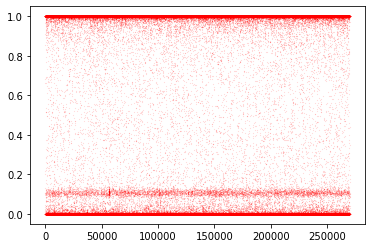

In [79]:
plt.plot(senti_val, 'ro', markersize = 0.1, alpha = 0.5)

In [84]:
senti_val[4]

3.0493895e-06

In [85]:
df['sentiment'] = senti_val

In [86]:
df.to_csv("./data/news_guardian_sentiment.csv", index = False)